In [1]:
import polars as pl
import numpy as np
from typing import List

def diff_expr(col: str, lag: int = 1) -> pl.Expr:
    return (pl.col(col) - pl.col(col).shift(lag)).alias(f"{col}_diff_{lag}")

def second_order_diff_expr(col: str, lag: int = 1) -> pl.Expr:
    # 二阶差分 = 一阶差分的差分
    first_diff = pl.col(col) - pl.col(col).shift(lag)
    second_diff = first_diff - first_diff.shift(lag)
    return second_diff.alias(f"{col}_second_order_diff_{lag}")

def momentum_ratio_expr(col: str, lag: int = 200) -> pl.Expr:
    # 动量比率 = x_t / x_{t-lag}
    return (pl.col(col) / (pl.col(col).shift(lag) + 1e-8)).alias(f"{col}_momentum_ratio_{lag}")

def rolling_volatility_expr(col: str, window: int) -> pl.Expr:
    return pl.col(col).rolling_std(window).alias(f"{col}_volatility_{window}")

def lag_exprs(col: str, lags: List[int]) -> List[pl.Expr]:
    return [
        pl.col(col).shift(lag).alias(f"{col}_lag_{lag}")
        for lag in lags
    ]


def cross_comb_expr(a: str, b: str) -> pl.Expr:
    return (pl.col(a) + (pl.col(b) + 1e-8)).alias(f"{a}_comb_{b}")

def cols_to_transforms(
        df: pl.DataFrame,
        exclude_cols: List[str] = None
) -> List[str]:
    if exclude_cols is None:
        exclude_cols = ['px', 'timestamp', 'timestamp_dt', 'symbol']

    if isinstance(df, pl.LazyFrame):
        cols = df.collect_schema().names()
    else:
        cols = df.columns

    cols = [
        col for col in cols
        if col not in exclude_cols and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_scaled')
        )
    ]

    return cols

def batch_apply_single_exprs(
        window: int,
        lag: int,
        cols: List[str] = None
) -> List[str]:
    single_exprs = []
    # single features transformation
    for col in cols:
        single_exprs.extend([
            diff_expr(col),
            second_order_diff_expr(col),
            momentum_ratio_expr(col, lag),
            rolling_volatility_expr(col, window),
        ])
        single_exprs.extend(lag_exprs(col, [10, 20, 50, 100, 200]))

    return single_exprs

def batch_apply_multi_exprs(
        cols: List[str] = None
) -> List[str]:
    multi_exprs = []

    n = len(cols)
    for i in range(n):
        for j in range(i + 1, n):
            a, b = cols[i], cols[j]
            multi_exprs.extend([
                cross_comb_expr(a, b),
            ])

    return multi_exprs

def batch_apply_transforms(
        df_to_transforms: pl.DataFrame,
        window: int,
        lag: int,
        exclude_cols: List[str] = None
) -> pl.DataFrame:
    base_cols = cols_to_transforms(df_to_transforms, exclude_cols)
   
    single_exprs = batch_apply_single_exprs(window, lag, base_cols)
    multi_exprs = batch_apply_multi_exprs(base_cols)

    exprs = single_exprs + multi_exprs
    return df_to_transforms.with_columns(single_exprs)



In [2]:
import polars as pl
import numpy as np
from typing import List
from tqdm import tqdm

def split_df_by_week(
        origin_input_df: pl.DataFrame,
        ts_col: str = "timestamp"
) -> List[pl.DataFrame]:
    origin_input_df = origin_input_df.with_columns([
        pl.col(ts_col).cast(pl.Datetime).alias(f"{ts_col}_dt")
    ])

    origin_input_df = origin_input_df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1w").alias("week_start")
    ])

    unique_weeks = origin_input_df.select("week_start").unique().sort("week_start")

    weekly_dfs = [
        origin_input_df.filter(pl.col("week_start") == wk).drop("week_start")
        for wk in unique_weeks["week_start"]
    ]

    return weekly_dfs


def clean_df_drop_nulls(
        df_to_clean: pl.DataFrame,
        null_threshold: int = 10000,
        verbose: bool = True
) -> pl.DataFrame:
    pd_df = df_to_clean.to_pandas()

    null_counts = pd_df.isnull().sum()
    cols_to_drop = null_counts[null_counts > null_threshold].index

    pd_df_cleaned = pd_df.drop(columns=cols_to_drop)
    pd_df_clean = pd_df_cleaned.dropna()
    pl_df_clean = pl.from_pandas(pd_df_clean)

    if verbose:
        max_null_col = null_counts.idxmax()
        max_null_count = null_counts.max()
        print("各列空值数量：")
        print(null_counts[null_counts > 0])
        print(f"删除空值超过 {null_threshold} 的列：{list(cols_to_drop)}")
        print(f"删除列后，DataFrame形状：{pd_df_cleaned.shape}")
        print(f"空值最多的列是：{max_null_col}，共有 {max_null_count} 个空值")
        print(f"删除空值行后，DataFrame形状：{pd_df_clean.shape}")

    return pl_df_clean

def avg_steps_to_volatility(prices: np.ndarray, target_ratio: float) -> int:
    n = len(prices)
    steps_list = []
    for i in tqdm(range(n), desc=f"cal abs change {target_ratio*100:.2f}% avg steps"):
        start_price = prices[i]
        steps = -1
        for j in range(i + 1, n):
            change = abs(prices[j] / start_price - 1)
            if change >= target_ratio:
                steps = j - i
                break
        if steps != -1:
            steps_list.append(steps)
    if len(steps_list) == 0:
        return -1
    return int(np.mean(steps_list))

def future_return_expr(price_col: str, step: int) -> pl.Expr:
    return ((pl.col(price_col).shift(-step) - pl.col(price_col)) / pl.col(price_col)).alias(f"future_return_{step}")

def rolling_minmax_scaled_expr(
        col: str,
        min_col: str,
        max_col: str,
        scaled_col: str
) -> pl.Expr:
    return (
        ((pl.col(col) - pl.col(min_col)) / (pl.col(max_col) - pl.col(min_col) + 1e-9))
        .clip(0.0, 1.0)
        .fill_null(0.5)
        .alias(scaled_col)
    )

def rolling_minmax_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')  # scaled 是最终产物，保留
           and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_rolling_max') or
                col.endswith('_rolling_min')
        )
    ]

    rolling_cols = []
    for column in columns_to_normalize:
        rolling_cols.extend([
            pl.col(column).rolling_max(window, min_samples=1).alias(f"{column}_rolling_max"),
            pl.col(column).rolling_min(window, min_samples=1).alias(f"{column}_rolling_min"),
        ])

    intermediate_cols = [
                            f"{column}_rolling_max" for column in columns_to_normalize
                        ] + [
                            f"{column}_rolling_min" for column in columns_to_normalize
                        ]

    return (
        rollin_df
        .with_columns(rolling_cols)
        .with_columns([
            rolling_minmax_scaled_expr(
                col=column,
                min_col=f"{column}_rolling_min",
                max_col=f"{column}_rolling_max",
                scaled_col=f"{column}_scaled"
            ) for column in columns_to_normalize
        ])
        .drop(intermediate_cols)
    )

def rolling_mean_tanh_scaled_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
        pl.col(col)
        .rolling_mean(window, min_samples=1)
        .tanh()
        .rolling_mean(window, min_samples=1)
        .alias(scaled_col)
    )

def rolling_mean_tanh_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        rolling_mean_tanh_scaled_expr(
            col=column,
            scaled_col=f"{column}_scaled",
            window=window
        ) for column in columns_to_normalize
    ])

def rolling_ic_ir_icto_index(
        df: pl.DataFrame,
        target_col: str,
        exclude_prefixes: list[str],
        window_size: int,
        step: int = 1,
) -> pl.DataFrame:
    feature_cols = [
        col for col in df.columns
        if col.endswith("_scaled") 
            and (col.startswith("z_") or col.startswith("raw_")) 
            and all(not col.startswith(prefix) for prefix in exclude_prefixes)
            and not col.startswith("future_return_")
            and col != "px"
    ]

    # feature_cols = [
    #     col for col in df.columns
    #     if col.startswith("z_") 
    #         and all(not col.startswith(prefix) for prefix in exclude_prefixes)
    #         and not col.startswith("future_return_")
    #         and col != "px"
    # ]

    n = df.height
    results = []
    prev_ranks = {}

    for start in tqdm(range(0, n - window_size + 1, step), desc="Rolling IC & ICTO"):
        end = start + window_size
        df_win = df.slice(start, window_size)

        # rank 转换
        df_ranked = df_win.with_columns([
            (pl.col(c).rank(method="average") / window_size).alias(c + "_rank") for c in feature_cols + [target_col]
        ])
        target_rank_col = target_col + "_rank"

        for feat in feature_cols:
            feat_rank_col = feat + "_rank"
            ic = df_ranked.select(
                pl.corr(pl.col(feat_rank_col), pl.col(target_rank_col)).alias("ic")
            ).to_series()[0]

            turnover = None
            if feat in prev_ranks:
                cur_ranks = df_ranked[feat_rank_col].to_numpy()
                prev = prev_ranks[feat]
                if len(prev) == len(cur_ranks):
                    turnover = np.mean(np.abs(cur_ranks - prev))

            # 更新 prev_ranks
            prev_ranks[feat] = df_ranked[feat_rank_col].to_numpy()

            results.append({
                "window_start": int(start),
                "window_end": int(end - 1),
                "factor": str(feat),
                "ic": float(ic) if not np.isnan(ic) else None,
                "turnover": float(turnover) if turnover is not None else None
            })

    df_result = pl.DataFrame(
        results,
        schema={
            "window_start": pl.Int64,
            "window_end": pl.Int64,
            "factor": pl.Utf8,
            "ic": pl.Float64,
            "turnover": pl.Float64,
        }
    )      
    return (
        df_result
        .group_by("factor")
        .agg([
            pl.mean("ic").alias("mean_ic"),
            pl.std("ic").alias("std_ic"),
            pl.mean("turnover").alias("mean_turnover")
        ])
        .with_columns([
            (pl.col("mean_ic") / pl.col("std_ic")).alias("ir"),
            (pl.col("mean_ic") / (pl.col("mean_turnover") + 1e-8)).abs().alias("icto")
        ])
        .sort("icto", descending=True)
    )

In [3]:
origin_df = pl.read_csv("C:/quant/data/binance_resampled_data/BTCUSDT_factors_threshold0.001_rolling2000.csv")
# # 先把那两列单独 shift
# shifted_cols = origin_df.select([
#     pl.col("raw_factor_buy_sell_vlm_diff").shift(-5).alias("raw_factor_buy_sell_vlm_diff_shifted"),
#     pl.col("z_factor_buy_sell_vlm_diff").shift(-5).alias("z_factor_buy_sell_vlm_diff_shifted"),
# ])

# 删除原来的两列
origin_df = origin_df.drop([ "z_factor_buy_sell_vlm_diff"])

# # 合并回去（按顺序拼接）
# origin_df = origin_df.with_columns([
#     shifted_cols["raw_factor_buy_sell_vlm_diff_shifted"],
#     shifted_cols["z_factor_buy_sell_vlm_diff_shifted"]
# ])

print(origin_df)
origin_df = batch_apply_transforms(origin_df, 200, 10)
origin_df = rolling_mean_tanh_normalize(origin_df, 200)
print(origin_df)
stds = origin_df.select([
    pl.col(col).std().alias(col) for col in origin_df.columns if origin_df[col].dtype in (pl.Float64, pl.Int64)
])
zero_std_cols = [col for col in stds.columns if stds[0, col] == 0.0]
print(zero_std_cols)
origin_df = origin_df.drop(zero_std_cols)
print(origin_df)


shape: (27_214, 114)
┌──────────────────┬──────────┬────────────┬─────────────┬───┬─────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ timestamp        ┆ px       ┆ sum_buy_sz ┆ sum_sell_sz ┆ … ┆ z_factor_momentum_t ┆ z_factor_order_sen ┆ z_factor_oi_moment ┆ z_factor_oi_moment │
│ ---              ┆ ---      ┆ ---        ┆ ---         ┆   ┆ rend_confir…        ┆ timent_diver…      ┆ um_punch           ┆ um_long_term…      │
│ i64              ┆ f64      ┆ f64        ┆ f64         ┆   ┆ ---                 ┆ ---                ┆ ---                ┆ ---                │
│                  ┆          ┆            ┆             ┆   ┆ f64                 ┆ f64                ┆ f64                ┆ f64                │
╞══════════════════╪══════════╪════════════╪═════════════╪═══╪═════════════════════╪════════════════════╪════════════════════╪════════════════════╡
│ 1744003134974000 ┆ 77116.4  ┆ 41.241     ┆ 18.209      ┆ … ┆ 0.759049            ┆ -0.668

In [4]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.mixture import GaussianMixture

import lightgbm as lgb
from catboost import CatBoostClassifier
import xgboost as xgb

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from sklearn.preprocessing import LabelEncoder
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def plot_last_n_rows_with_px(y_test, y_test_binary, y_pred_prob, px, std_array=None, n=700, m=-1, alpha=1):
    # 截取最后 n 行
    y_test_slice = y_test[n:m]
    y_test_binary_slice = y_test_binary[n:m]
    y_pred_prob_slice = y_pred_prob[n:m]
    px_slice = px[n:m]
    
    if std_array is not None:
        std_slice = std_array[n:m]
    else:
        std_slice = None

    time_index = np.arange(len(y_test_slice))

    fig, ax1 = plt.subplots(figsize=(16, 7))

    # # 原始收益
    # ax1.plot(time_index, y_test_slice, label="Original Future Returns", color='gray', alpha=0.8)
    # ax1.set_ylabel("Original Future Returns", color='gray')
    # ax1.tick_params(axis='y', labelcolor='gray')

    # GMM 标签
    ax2 = ax1.twinx()
    ax2.scatter(time_index, y_test_binary_slice, label="GMM Labels", color='tab:blue', marker='o', s=20, alpha=0.7)
    ax2.set_ylabel("GMM Labels (0 or 1)", color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylim(-0.1, 1.1)

    # 模型预测概率
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))
    ax3.plot(time_index, y_pred_prob_slice, label="MODEL Predicted Probability", color='tab:green', alpha=0.4)
    ax3.set_ylabel("MODEL Predicted Probability", color='tab:green')
    ax3.tick_params(axis='y', labelcolor='tab:green')
    ax3.set_ylim(-0.05, 1.05)

    # 价格线 (第4轴)
    ax4 = ax1.twinx()
    ax4.spines.right.set_position(("outward", 120))  # 再右移一层
    ax4.plot(time_index, px_slice, label="Price (px)", color='tab:blue', linestyle='--', alpha=0.6)

    # 加上下轨线
    if std_slice is not None:
        ax4.plot(time_index, px_slice + alpha * std_slice, label="Price + std", color='tab:gray', linestyle=':', alpha=0.4)
        ax4.plot(time_index, px_slice - alpha * std_slice, label="Price - std", color='tab:gray', linestyle=':', alpha=0.4)

    ax4.set_ylabel("Price (px)", color='tab:red')
    ax4.tick_params(axis='y', labelcolor='tab:red')

    # x轴
    ax1.set_xlabel("Time Index")
    plt.title(f"Compare Returns, Labels, Prediction & Price (Last {n} Rows)")

    # 图例
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_3, labels_3 = ax3.get_legend_handles_labels()
    lines_4, labels_4 = ax4.get_legend_handles_labels()

    ax1.legend(
        lines_1 + lines_2 + lines_3 + lines_4,
        labels_1 + labels_2 + labels_3 + labels_4,
        loc='upper left'
    )

    plt.tight_layout()
    plt.show()


In [6]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

def evaluate_with_confidence(
    y_true,
    y_pred_proba,                      
    model_name="Model",                    
    lower_thresh=0.2,                  
    upper_thresh=0.8,       
    print_report=True,
):

    # ===== 基础评估 (全样本) =====
    base_pred = (y_pred_proba >= 0.5).astype(int)
    base_acc = accuracy_score(y_true, base_pred)
    
    # ===== 置信预测评估 =====
    # 生成交易信号 (-1: 不交易, 0: 做空, 1: 做多)
    signals = np.full_like(y_pred_proba, fill_value=-1, dtype=int)
    signals[y_pred_proba <= lower_thresh] = 0
    signals[y_pred_proba >= upper_thresh] = 1
    
    # 计算置信预测指标
    mask = signals != -1
    conf_acc = accuracy_score(y_true[mask], signals[mask]) if any(mask) else np.nan
    trading_rate = mask.mean()
    
    # ===== 结果组织 =====
    eval_dict = {
        'model': model_name,
        'thresholds': f"{lower_thresh}-{upper_thresh}",
        'base_accuracy': base_acc,
        'confident_accuracy': conf_acc,
        'trading_rate': trading_rate,
        'conf_matrix': confusion_matrix(y_true[mask], signals[mask]) if any(mask) else None,
        'class_report': classification_report(y_true[mask], signals[mask], output_dict=True) if any(mask) else None,
        'y_test_binary': y_true, 
        'y_pred_proba': y_pred_proba, 
        'signal': signals,
    }
    
    # ===== 打印输出 =====
    if print_report:
        print(f"\n=== {model_name} 评估结果 ===")
        print(f"📊 全样本准确率: {base_acc:.4f}")
        print(f"✅ 自信预测准确率: {conf_acc:.4f} (阈值 {lower_thresh}-{upper_thresh})")
        print(f"📈 出手率: {trading_rate:.2%}")
        
        if any(mask):
            print("\n🧮 自信预测混淆矩阵:")
            print(eval_dict['conf_matrix'])
            
            print("\n📝 分类报告:")
            print(classification_report(y_true[mask], signals[mask]))
        else:
            print("⚠️ 无自信预测样本!")
    
    return eval_dict


In [7]:
import polars as pl
import numpy as np
from tqdm import tqdm

# //////////////////////////////
rolling_window = 300
alpha = 2

a_df = origin_df.with_columns([
    pl.col("px").rolling_std(window_size=rolling_window).alias("rolling_std"),
])

def label_by_future_std_with_duration_and_bars(px: np.ndarray, std: np.ndarray, ts: np.ndarray):
    n = len(px)
    labels = np.full(n, -1, dtype=np.int8)
    durations = np.full(n, -1, dtype=np.int64)  # 微秒差
    bar_counts = np.full(n, -1, dtype=np.int32) # bar 数

    for i in tqdm(range(n), desc="Labeling by future std"):
        anchor_price = px[i]
        anchor_ts = ts[i]

        for j in range(i + 1, n):
            upper_bound = anchor_price + alpha * std[j]
            lower_bound = anchor_price - alpha * std[j]

            if px[j] >= upper_bound:
                labels[i] = 1
                durations[i] = ts[j] - anchor_ts
                bar_counts[i] = j - i
                break
            elif px[j] <= lower_bound:
                labels[i] = 0
                durations[i] = ts[j] - anchor_ts
                bar_counts[i] = j - i
                break

    return labels, durations, bar_counts


px_np = a_df["px"].to_numpy()
std_np = a_df["rolling_std"].to_numpy()
ts_np = a_df["timestamp"].to_numpy()

labels_np, durations_np, bar_counts_np = label_by_future_std_with_duration_and_bars(px_np, std_np, ts_np)

a_df = a_df.with_columns([
    pl.Series("future_std_label", labels_np),
    pl.Series("label_duration_us", durations_np),
    pl.Series("label_bar_count", bar_counts_np),
])

a_df_filtered = a_df.filter(pl.col("future_std_label") >= 0)
a_df_filtered = clean_df_drop_nulls(a_df_filtered)
print(a_df_filtered)

weekly_dataframes = split_df_by_week(a_df_filtered)
print("num weekly dfs:", len(weekly_dataframes))


Labeling by future std: 100%|████████████████████████████████████████████████████████████████████████████| 27214/27214 [00:01<00:00, 20723.85it/s]


各列空值数量：
sum_buy_sz_diff_1                                        1
sum_buy_sz_second_order_diff_1                           2
sum_buy_sz_momentum_ratio_10                            10
sum_buy_sz_volatility_200                              199
sum_buy_sz_lag_10                                       10
                                                      ... 
z_factor_oi_momentum_long_term_punch_lag_20_scaled      20
z_factor_oi_momentum_long_term_punch_lag_50_scaled      50
z_factor_oi_momentum_long_term_punch_lag_100_scaled    100
z_factor_oi_momentum_long_term_punch_lag_200_scaled    200
rolling_std                                            299
Length: 1955, dtype: int64
删除空值超过 10000 的列：[]
删除列后，DataFrame形状：(27042, 2173)
空值最多的列是：rolling_std，共有 299 个空值
删除空值行后，DataFrame形状：(26743, 2173)
shape: (26_743, 2_173)
┌──────────────────┬──────────┬────────────┬─────────────┬───┬─────────────┬──────────────────┬───────────────────┬─────────────────┐
│ timestamp        ┆ px       ┆ sum_buy_sz ┆ 

In [8]:
mean_duration = a_df_filtered.select(pl.col("label_duration_us").mean()).item()
mean_bar_count = a_df_filtered.select(pl.col("label_bar_count").mean()).item()
mean_std = a_df_filtered.select(pl.col("rolling_std").mean()).item()

print(f"Mean duration (microseconds): {mean_duration/1_000_000}")
print(f"Mean bar count: {mean_bar_count}")
print(mean_std)
print(mean_std * alpha)
print((mean_std * alpha) / 90000)


Mean duration (microseconds): 27239.54232460831
Mean bar count: 129.39064428074636
632.8163537549661
1265.6327075099323
0.014062585638999248


In [9]:
import polars as pl
import numpy as np
from tqdm import tqdm

rolling_window = 300
alpha = 4

a_df = (
    origin_df
    .with_columns([
        pl.col("px").rolling_std(window_size=rolling_window).alias("rolling_std"),
    ])
)

def label_by_future_std(px: np.ndarray, std: np.ndarray) -> np.ndarray:
    n = len(px)
    labels = np.full(n, -1)  # 初始化为 -1（未触发）

    for i in tqdm(range(n), desc="Labeling by future std"):
        anchor_price = px[i]
        for j in range(i + 1, n):
            upper_bound = anchor_price + alpha * std[j]
            lower_bound = anchor_price - alpha * std[j]
            if px[j] >= upper_bound:
                labels[i] = 1
                break
            elif px[j] <= lower_bound:
                labels[i] = 0
                break

            else:
                labels[i] = -1

    return labels

px_np = a_df["px"].to_numpy()
std_np = a_df["rolling_std"].to_numpy()

labels_np = label_by_future_std(px_np, std_np)

a_df = a_df.with_columns(pl.Series("future_std_label", labels_np))
print(a_df)
a_df_filtered = a_df.filter(pl.col("future_std_label") >= 0)
a_df_filtered = clean_df_drop_nulls(a_df_filtered)
print(a_df_filtered)

weekly_dataframes = split_df_by_week(a_df_filtered)
print("num weekly dfs: ", len(weekly_dataframes))

Labeling by future std: 100%|█████████████████████████████████████████████████████████████████████████████| 27214/27214 [00:06<00:00, 3952.18it/s]


shape: (27_214, 2_171)
┌──────────────────┬──────────┬────────────┬─────────────┬───┬─────────────────────────┬─────────────────────────┬─────────────┬──────────────────┐
│ timestamp        ┆ px       ┆ sum_buy_sz ┆ sum_sell_sz ┆ … ┆ z_factor_oi_momentum_lo ┆ z_factor_oi_momentum_lo ┆ rolling_std ┆ future_std_label │
│ ---              ┆ ---      ┆ ---        ┆ ---         ┆   ┆ ng_term…                ┆ ng_term…                ┆ ---         ┆ ---              │
│ i64              ┆ f64      ┆ f64        ┆ f64         ┆   ┆ ---                     ┆ ---                     ┆ f64         ┆ i64              │
│                  ┆          ┆            ┆             ┆   ┆ f64                     ┆ f64                     ┆             ┆                  │
╞══════════════════╪══════════╪════════════╪═════════════╪═══╪═════════════════════════╪═════════════════════════╪═════════════╪══════════════════╡
│ 1744003134974000 ┆ 77116.4  ┆ 41.241     ┆ 18.209      ┆ … ┆ null                    ┆ 

Fold 0: Train 0~2, Val 3, Test 4
Train: 2025-04-07 07:49:55.639000 to 2025-04-27 23:56:42.096000
Val: 2025-04-28 00:06:59.957000 to 2025-05-04 23:55:19.066000
Test: 2025-05-05 00:01:39.539000 to 2025-05-11 23:57:01.156000

=== lgb_model 评估结果 ===
📊 全样本准确率: 0.5193
✅ 自信预测准确率: 0.5240 (阈值 0.2-0.8)
📈 出手率: 89.66%

🧮 自信预测混淆矩阵:
[[ 16 673]
 [  0 725]]

📝 分类报告:
              precision    recall  f1-score   support

           0       1.00      0.02      0.05       689
           1       0.52      1.00      0.68       725

    accuracy                           0.52      1414
   macro avg       0.76      0.51      0.36      1414
weighted avg       0.75      0.52      0.37      1414


=== lgb_model 评估结果 ===
📊 全样本准确率: 0.8836
✅ 自信预测准确率: 0.8883 (阈值 0.2-0.8)
📈 出手率: 97.00%

🧮 自信预测混淆矩阵:
[[   0  241]
 [   1 1924]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       241
           1       0.89      1.00      0.94      1925

    accuracy         

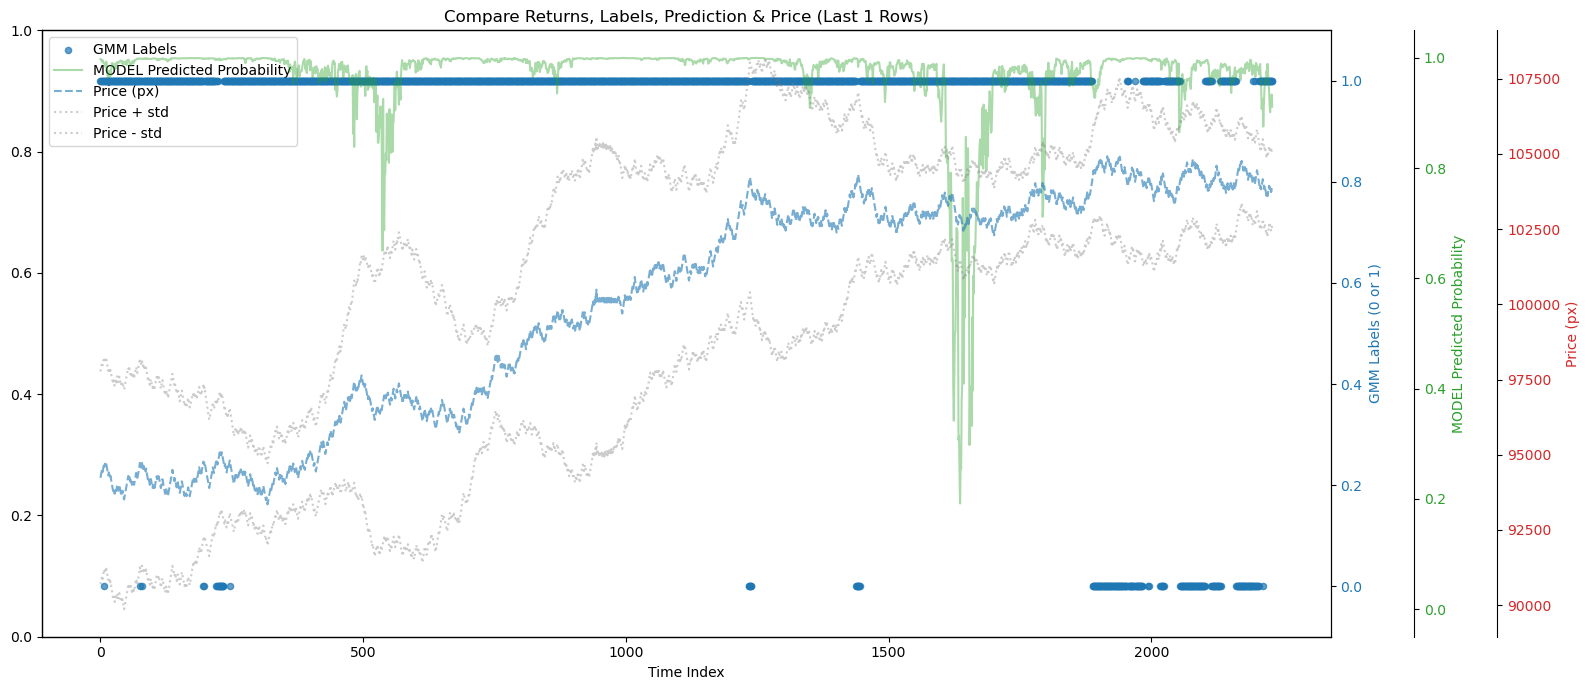

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71815 | val_0_accuracy: 0.49841 |  0:00:00s
epoch 5  | loss: 0.20913 | val_0_accuracy: 0.52378 |  0:00:03s
epoch 10 | loss: 0.15792 | val_0_accuracy: 0.51997 |  0:00:05s
epoch 15 | loss: 0.15347 | val_0_accuracy: 0.49334 |  0:00:08s
epoch 20 | loss: 0.13418 | val_0_accuracy: 0.45529 |  0:00:11s
epoch 25 | loss: 0.12389 | val_0_accuracy: 0.51363 |  0:00:14s
epoch 30 | loss: 0.12473 | val_0_accuracy: 0.50856 |  0:00:16s

Early stopping occurred at epoch 34 with best_epoch = 14 and best_val_0_accuracy = 0.54788


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.5479
✅ 自信预测准确率: 0.5042 (阈值 0.2-0.8)
📈 出手率: 83.01%

🧮 自信预测混淆矩阵:
[[ 32 644]
 [  5 628]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.86      0.05      0.09       676
           1       0.49      0.99      0.66       633

    accuracy                           0.50      1309
   macro avg       0.68      0.52      0.37      1309
weighted avg       0.69      0.50      0.37      1309


=== tabnet 评估结果 ===
📊 全样本准确率: 0.8365
✅ 自信预测准确率: 0.8578 (阈值 0.2-0.8)
📈 出手率: 91.36%

🧮 自信预测混淆矩阵:
[[   2  227]
 [  63 1748]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.03      0.01      0.01       229
           1       0.89      0.97      0.92      1811

    accuracy                           0.86      2040
   macro avg       0.46      0.49      0.47      2040
weighted avg       0.79      0.86      0.82      2040



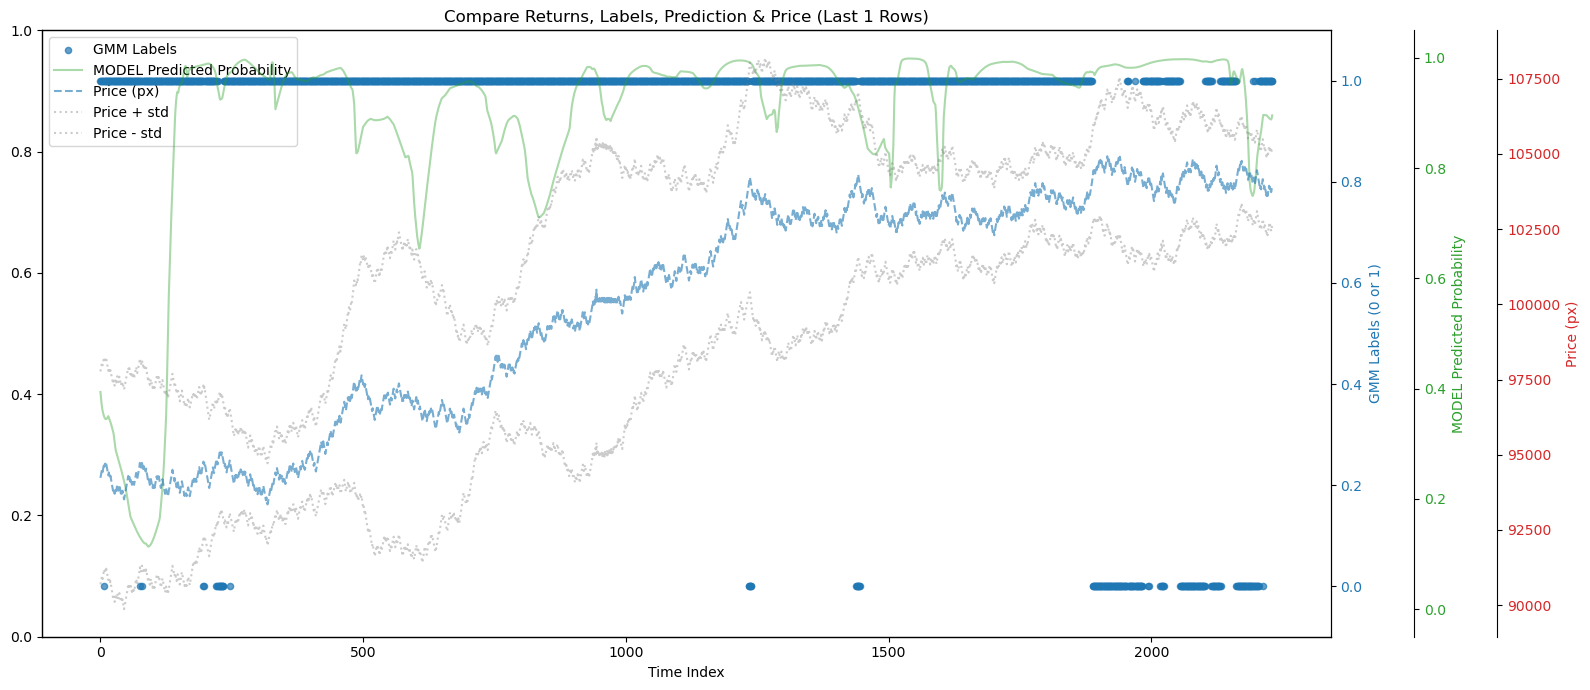

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71815 | val_0_accuracy: 0.49841 |  0:00:00s
epoch 5  | loss: 0.20913 | val_0_accuracy: 0.52378 |  0:00:03s
epoch 10 | loss: 0.15792 | val_0_accuracy: 0.51997 |  0:00:05s
epoch 15 | loss: 0.15347 | val_0_accuracy: 0.49334 |  0:00:08s
epoch 20 | loss: 0.13418 | val_0_accuracy: 0.45529 |  0:00:11s
epoch 25 | loss: 0.12389 | val_0_accuracy: 0.51363 |  0:00:13s
epoch 30 | loss: 0.12473 | val_0_accuracy: 0.50856 |  0:00:16s

Early stopping occurred at epoch 34 with best_epoch = 14 and best_val_0_accuracy = 0.54788


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5479
✅ 自信预测准确率: 0.5042 (阈值 0.2-0.8)
📈 出手率: 83.01%

🧮 自信预测混淆矩阵:
[[ 32 644]
 [  5 628]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.86      0.05      0.09       676
           1       0.49      0.99      0.66       633

    accuracy                           0.50      1309
   macro avg       0.68      0.52      0.37      1309
weighted avg       0.69      0.50      0.37      1309


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.8365
✅ 自信预测准确率: 0.8578 (阈值 0.2-0.8)
📈 出手率: 91.36%

🧮 自信预测混淆矩阵:
[[   2  227]
 [  63 1748]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.03      0.01      0.01       229
           1       0.89      0.97      0.92      1811

    accuracy                           0.86      2040
   macro avg       0.46      0.49      0.47      2040
weighted avg       0.79      0.86      0.82      2040



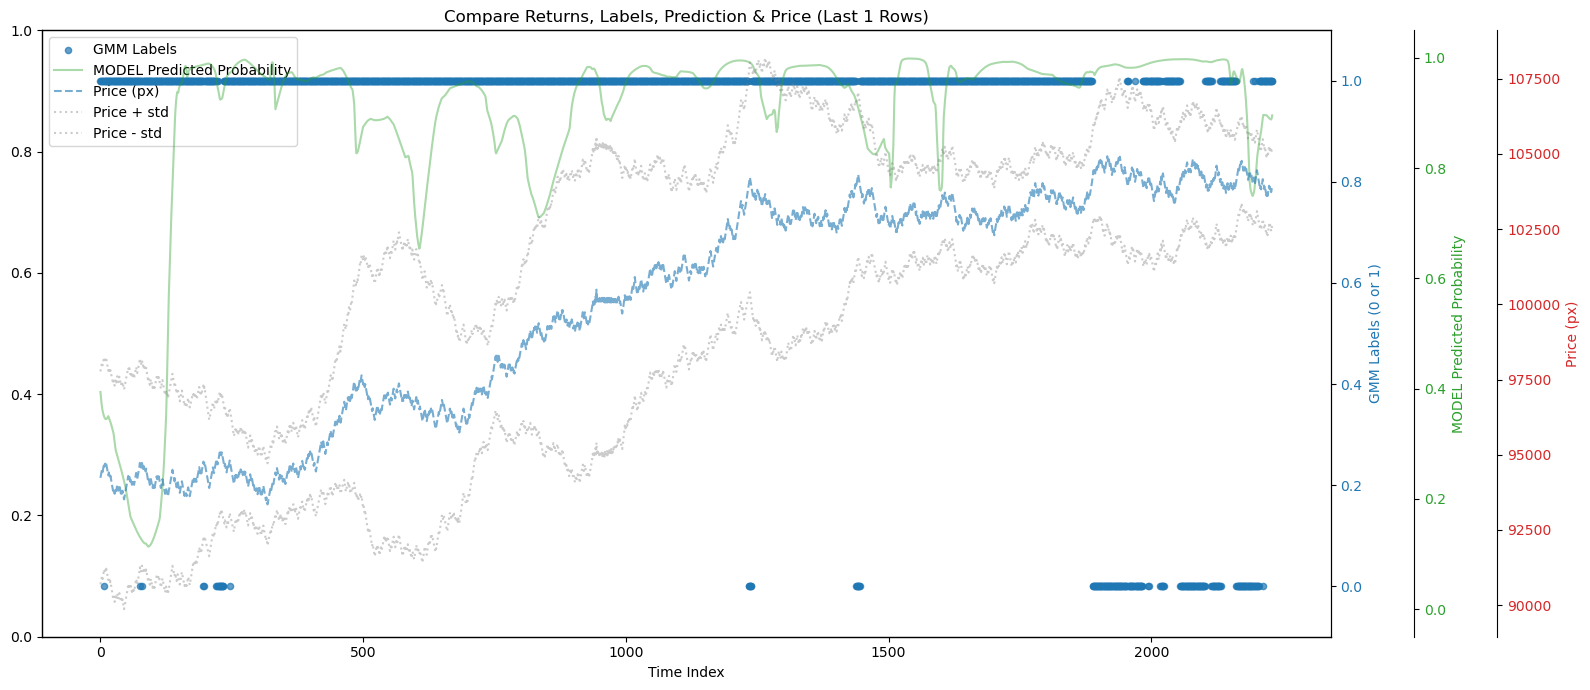

Test Week 3 Evaluation Completed
Fold 1: Train 1~3, Val 4, Test 5
Train: 2025-04-14 00:03:18.378000 to 2025-05-04 23:55:19.066000
Val: 2025-05-05 00:01:39.539000 to 2025-05-11 23:57:01.156000
Test: 2025-05-12 00:05:11.740000 to 2025-05-18 23:59:34.191000

=== lgb_model 评估结果 ===
📊 全样本准确率: 0.8486
✅ 自信预测准确率: 0.8959 (阈值 0.2-0.8)
📈 出手率: 82.18%

🧮 自信预测混淆矩阵:
[[   2  178]
 [  13 1642]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.13      0.01      0.02       180
           1       0.90      0.99      0.95      1655

    accuracy                           0.90      1835
   macro avg       0.52      0.50      0.48      1835
weighted avg       0.83      0.90      0.85      1835


=== lgb_model 评估结果 ===
📊 全样本准确率: 0.7662
✅ 自信预测准确率: 0.7731 (阈值 0.2-0.8)
📈 出手率: 97.81%

🧮 自信预测混淆矩阵:
[[   3  466]
 [   0 1585]]

📝 分类报告:
              precision    recall  f1-score   support

           0       1.00      0.01      0.01       469
           1       0.77      1.00      

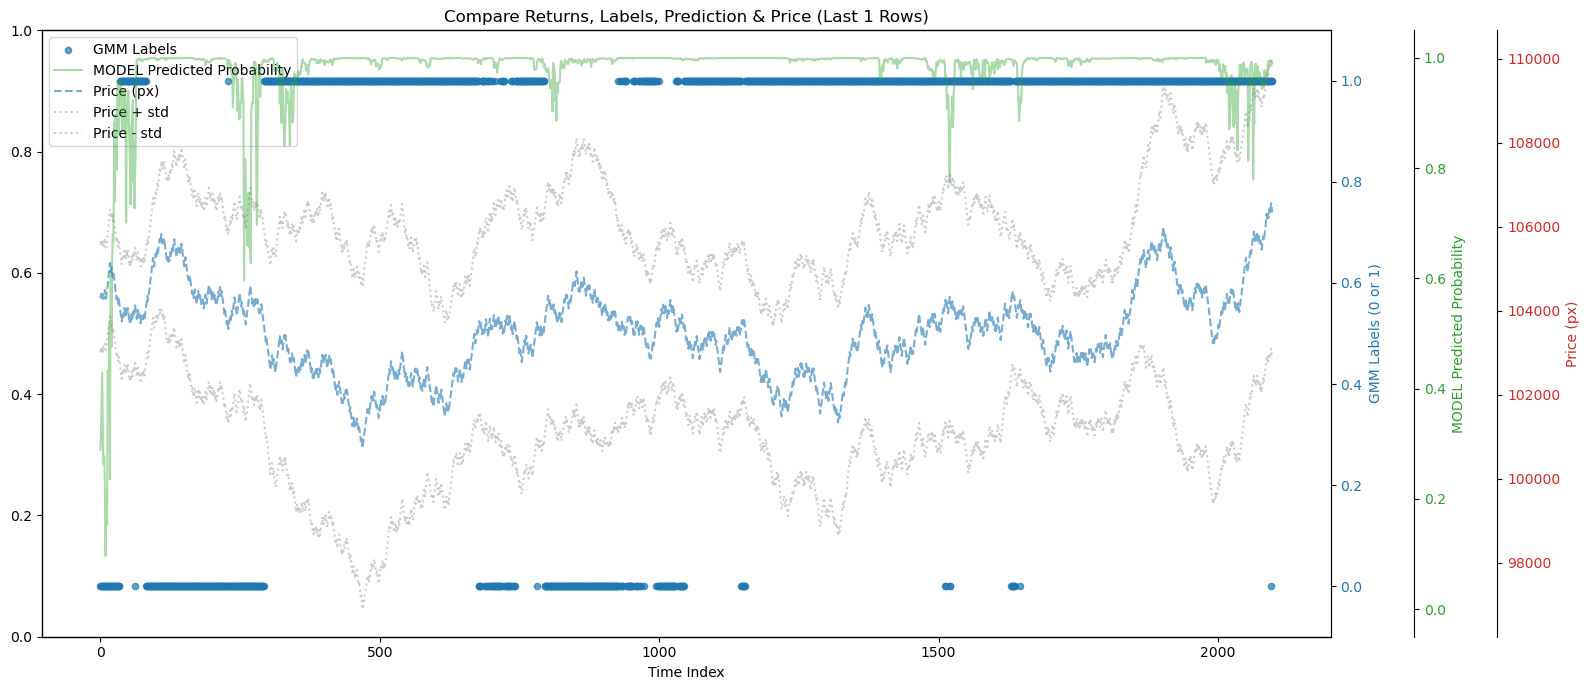

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.87534 | val_0_accuracy: 0.89207 |  0:00:00s
epoch 5  | loss: 0.31111 | val_0_accuracy: 0.89207 |  0:00:01s
epoch 10 | loss: 0.21554 | val_0_accuracy: 0.74116 |  0:00:03s
epoch 15 | loss: 0.17499 | val_0_accuracy: 0.68652 |  0:00:04s
epoch 20 | loss: 0.15794 | val_0_accuracy: 0.76176 |  0:00:06s

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_accuracy = 0.89207


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.8921
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!

=== tabnet 评估结果 ===
📊 全样本准确率: 0.7571
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!


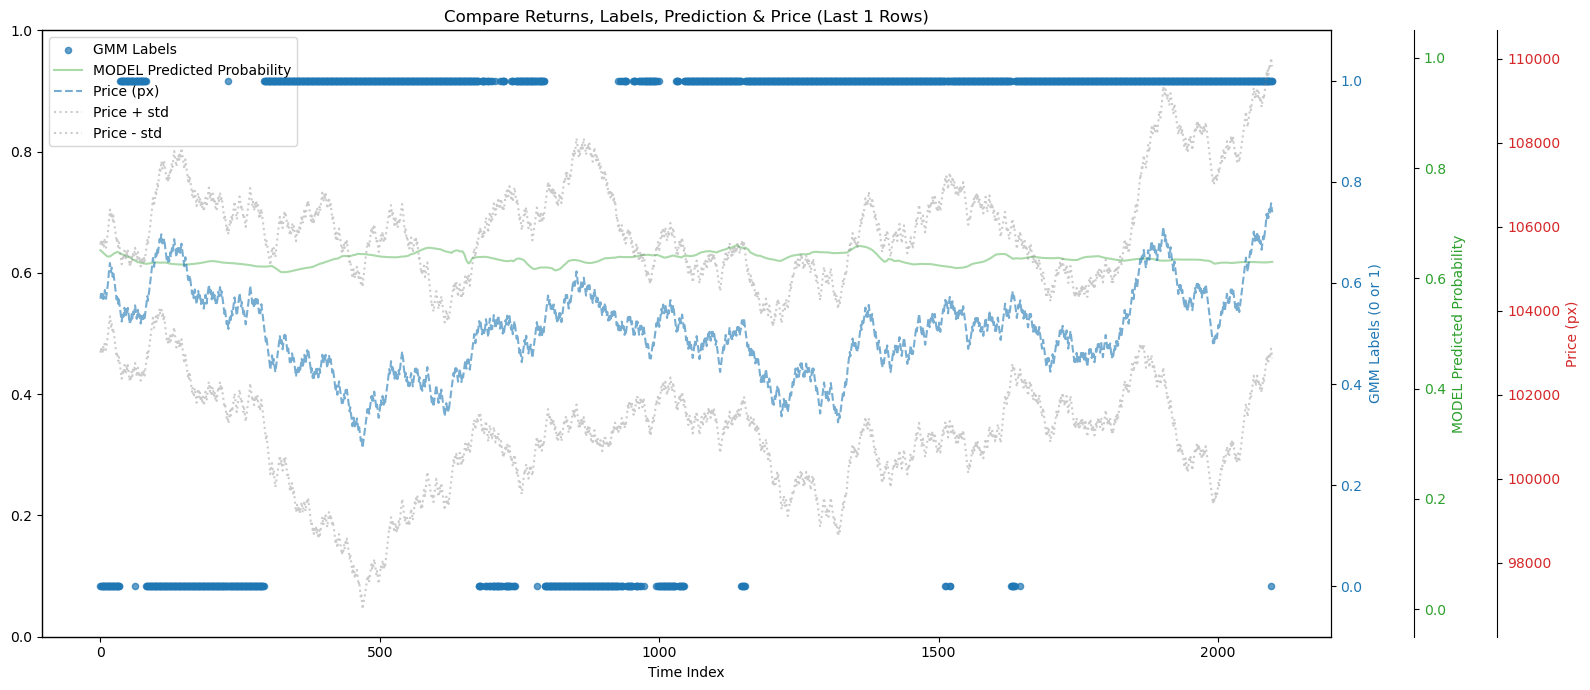

epoch 0  | loss: 0.39323 | val_0_accuracy: 0.72459 |  0:00:00s
epoch 5  | loss: 0.1834  | val_0_accuracy: 0.79221 |  0:00:01s
epoch 10 | loss: 0.16554 | val_0_accuracy: 0.74877 |  0:00:03s
epoch 15 | loss: 0.14742 | val_0_accuracy: 0.77743 |  0:00:04s

Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_accuracy = 0.84729


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetr


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.8473
✅ 自信预测准确率: 0.8675 (阈值 0.2-0.8)
📈 出手率: 74.34%

🧮 自信预测混淆矩阵:
[[   0  220]
 [   0 1440]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       220
           1       0.87      1.00      0.93      1440

    accuracy                           0.87      1660
   macro avg       0.43      0.50      0.46      1660
weighted avg       0.75      0.87      0.81      1660


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.7152
✅ 自信预测准确率: 0.7455 (阈值 0.2-0.8)
📈 出手率: 78.57%

🧮 自信预测混淆矩阵:
[[   5  417]
 [   3 1225]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.62      0.01      0.02       422
           1       0.75      1.00      0.85      1228

    accuracy                           0.75      1650
   macro avg       0.69      0.50      0.44      1650
weighted avg       0.72      0.75      0.64      1650



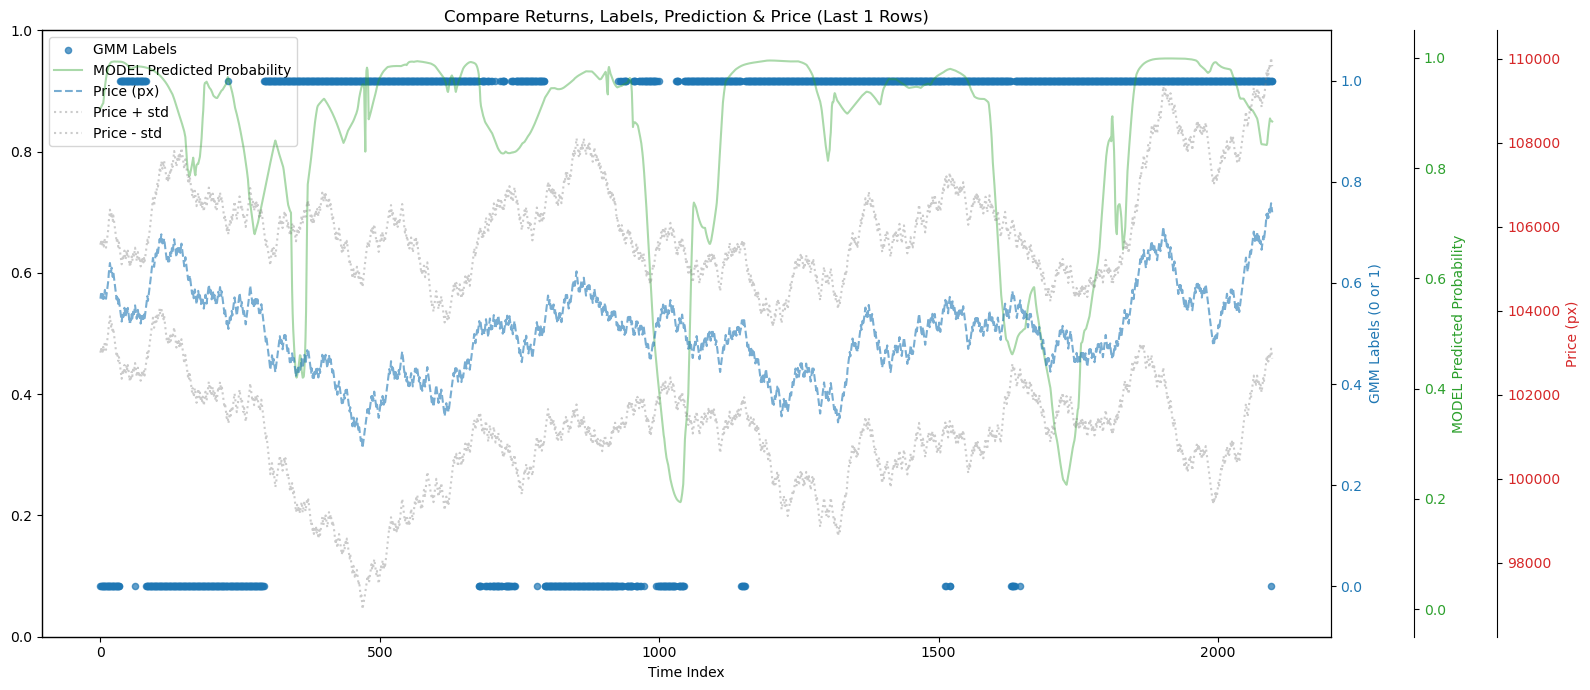

Test Week 4 Evaluation Completed
Fold 2: Train 2~4, Val 5, Test 6
Train: 2025-04-21 00:06:22.525000 to 2025-05-11 23:57:01.156000
Val: 2025-05-12 00:05:11.740000 to 2025-05-18 23:59:34.191000
Test: 2025-05-19 00:00:37.074000 to 2025-05-25 23:57:24.031000

=== lgb_model 评估结果 ===
📊 全样本准确率: 0.7414
✅ 自信预测准确率: 0.7481 (阈值 0.2-0.8)
📈 出手率: 93.38%

🧮 自信预测混淆矩阵:
[[   2  485]
 [   9 1465]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.18      0.00      0.01       487
           1       0.75      0.99      0.86      1474

    accuracy                           0.75      1961
   macro avg       0.47      0.50      0.43      1961
weighted avg       0.61      0.75      0.65      1961


=== lgb_model 评估结果 ===
📊 全样本准确率: 0.6225
✅ 自信预测准确率: 0.6306 (阈值 0.2-0.8)
📈 出手率: 94.72%

🧮 自信预测混淆矩阵:
[[   0 1108]
 [  32 1946]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1108
           1       0.64      0.98      

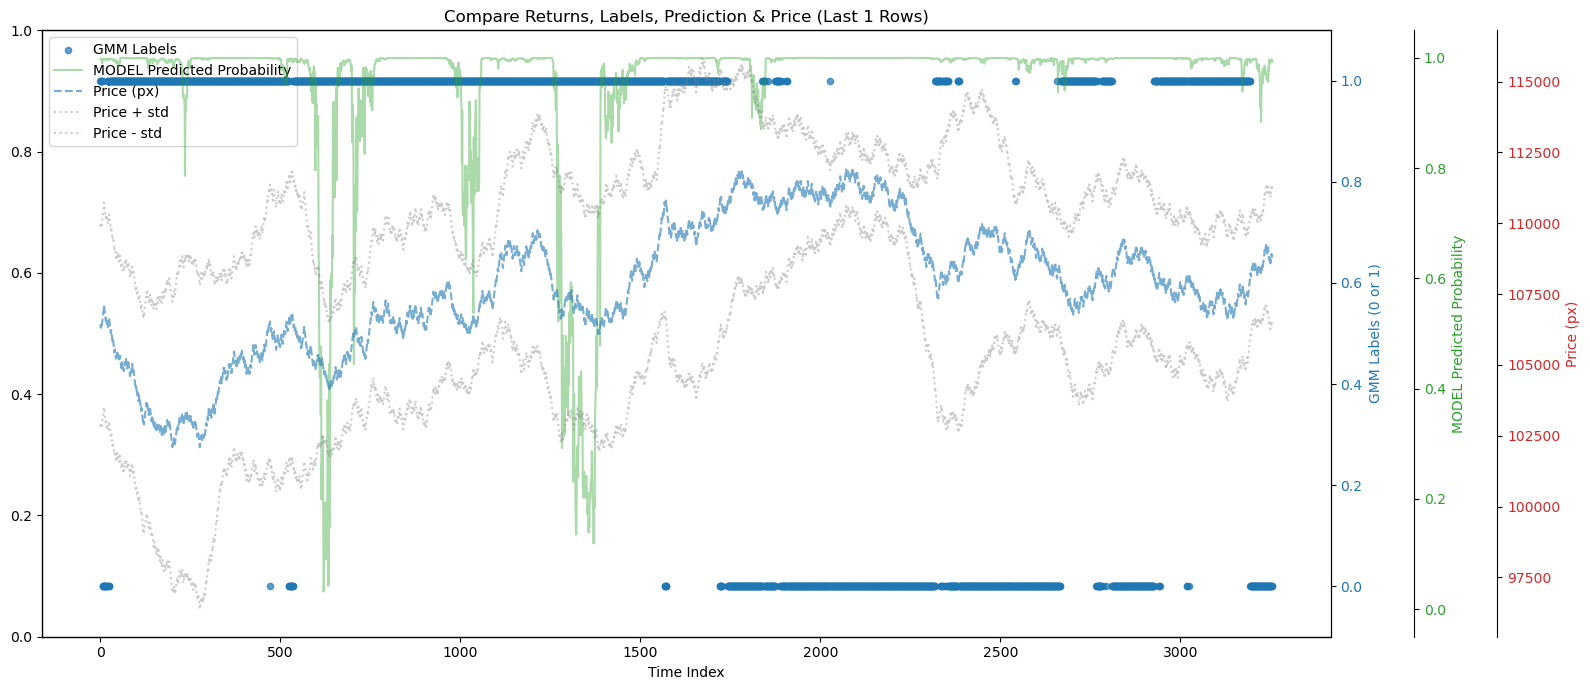

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.86938 | val_0_accuracy: 0.75714 |  0:00:00s
epoch 5  | loss: 0.28544 | val_0_accuracy: 0.75952 |  0:00:01s
epoch 10 | loss: 0.18766 | val_0_accuracy: 0.78905 |  0:00:03s
epoch 15 | loss: 0.16942 | val_0_accuracy: 0.76    |  0:00:04s
epoch 20 | loss: 0.16113 | val_0_accuracy: 0.70762 |  0:00:06s
epoch 25 | loss: 0.15223 | val_0_accuracy: 0.67571 |  0:00:07s
epoch 30 | loss: 0.13904 | val_0_accuracy: 0.71333 |  0:00:08s

Early stopping occurred at epoch 33 with best_epoch = 13 and best_val_0_accuracy = 0.81048


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.8105
✅ 自信预测准确率: 0.8266 (阈值 0.2-0.8)
📈 出手率: 70.29%

🧮 自信预测混淆矩阵:
[[  18  242]
 [  14 1202]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.56      0.07      0.12       260
           1       0.83      0.99      0.90      1216

    accuracy                           0.83      1476
   macro avg       0.70      0.53      0.51      1476
weighted avg       0.78      0.83      0.77      1476


=== tabnet 评估结果 ===
📊 全样本准确率: 0.6568
✅ 自信预测准确率: 0.6727 (阈值 0.2-0.8)
📈 出手率: 74.92%

🧮 自信预测混淆矩阵:
[[  51  773]
 [  26 1591]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.66      0.06      0.11       824
           1       0.67      0.98      0.80      1617

    accuracy                           0.67      2441
   macro avg       0.67      0.52      0.46      2441
weighted avg       0.67      0.67      0.57      2441



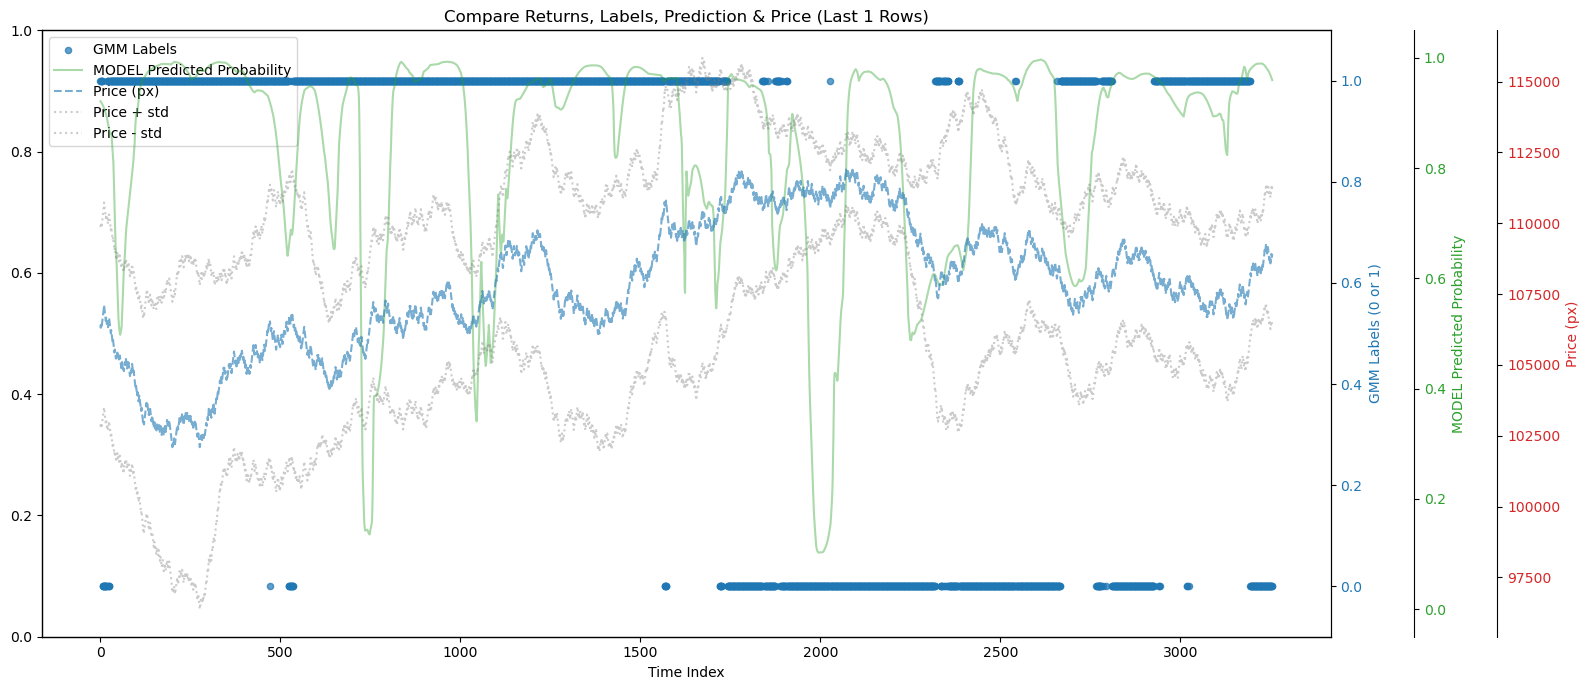

epoch 0  | loss: 0.28427 | val_0_accuracy: 0.77619 |  0:00:00s
epoch 5  | loss: 0.17496 | val_0_accuracy: 0.68762 |  0:00:01s
epoch 10 | loss: 0.16685 | val_0_accuracy: 0.74048 |  0:00:03s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_accuracy = 0.81381


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetr


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.8138
✅ 自信预测准确率: 0.7959 (阈值 0.2-0.8)
📈 出手率: 69.76%

🧮 自信预测混淆矩阵:
[[   0  299]
 [   0 1166]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       299
           1       0.80      1.00      0.89      1166

    accuracy                           0.80      1465
   macro avg       0.40      0.50      0.44      1465
weighted avg       0.63      0.80      0.71      1465


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5353
✅ 自信预测准确率: 0.5017 (阈值 0.2-0.8)
📈 出手率: 62.95%

🧮 自信预测混淆矩阵:
[[   0  992]
 [  30 1029]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       992
           1       0.51      0.97      0.67      1059

    accuracy                           0.50      2051
   macro avg       0.25      0.49      0.33      2051
weighted avg       0.26      0.50      0.35      2051



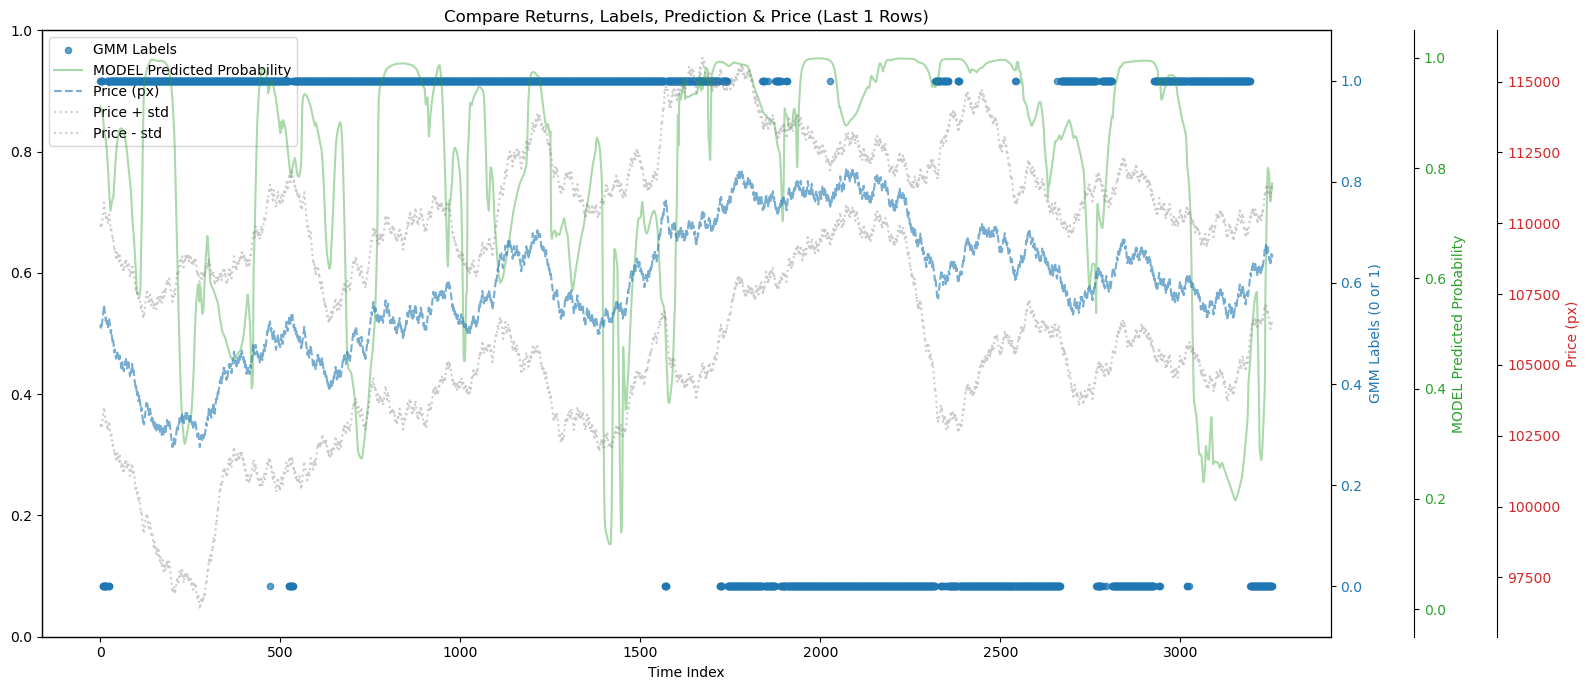

Test Week 5 Evaluation Completed
Fold 3: Train 3~5, Val 6, Test 7
Train: 2025-04-28 00:06:59.957000 to 2025-05-18 23:59:34.191000
Val: 2025-05-19 00:00:37.074000 to 2025-05-25 23:57:24.031000
Test: 2025-05-26 00:01:11.960000 to 2025-06-01 23:52:35.215000

=== lgb_model 评估结果 ===
📊 全样本准确率: 0.6661
✅ 自信预测准确率: 0.6809 (阈值 0.2-0.8)
📈 出手率: 90.88%

🧮 自信预测混淆矩阵:
[[  11  935]
 [  10 2005]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.52      0.01      0.02       946
           1       0.68      1.00      0.81      2015

    accuracy                           0.68      2961
   macro avg       0.60      0.50      0.42      2961
weighted avg       0.63      0.68      0.56      2961


=== lgb_model 评估结果 ===
📊 全样本准确率: 0.0965
✅ 自信预测准确率: 0.0930 (阈值 0.2-0.8)
📈 出手率: 94.19%

🧮 自信预测混淆矩阵:
[[   3 1736]
 [   0  175]]

📝 分类报告:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      1739
           1       0.09      1.00      

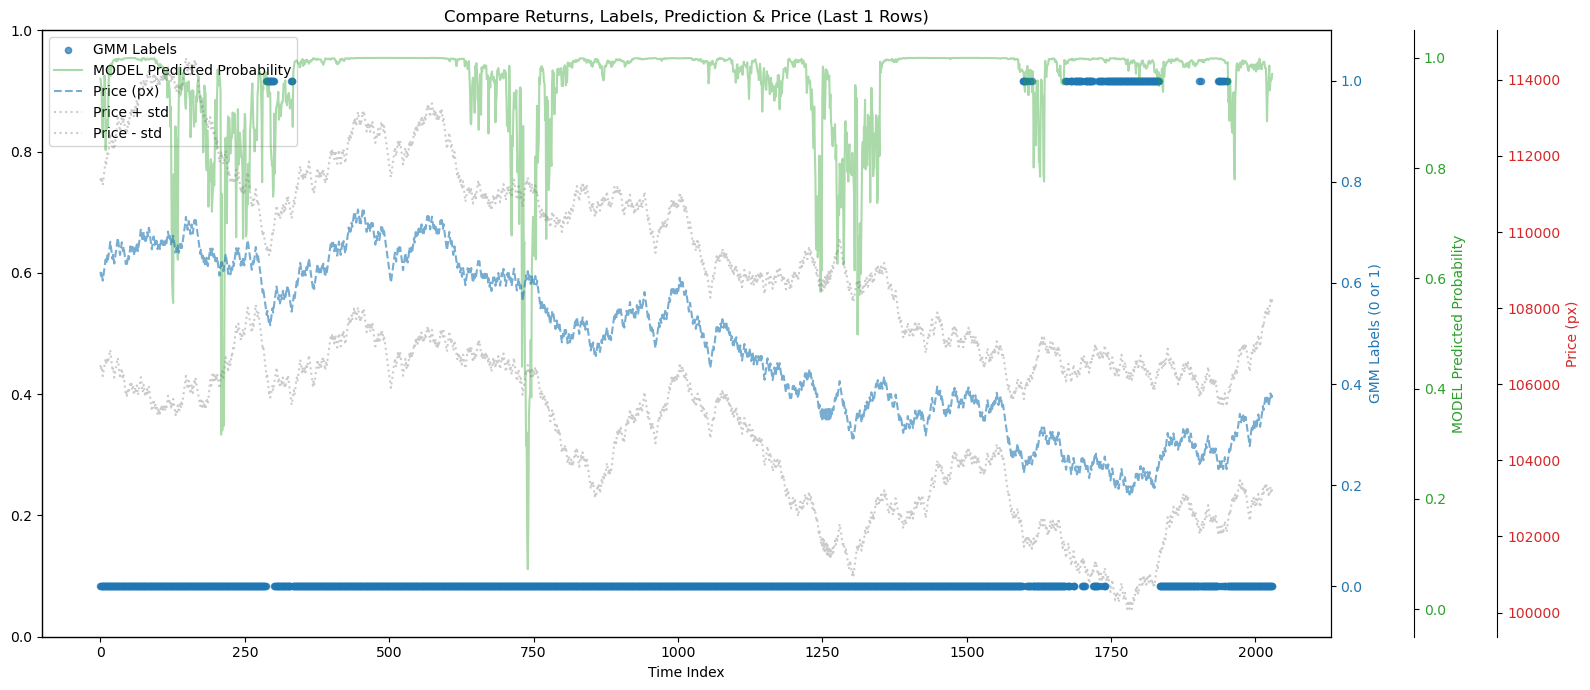

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.93436 | val_0_accuracy: 0.65991 |  0:00:00s
epoch 5  | loss: 0.27565 | val_0_accuracy: 0.68293 |  0:00:01s
epoch 10 | loss: 0.18511 | val_0_accuracy: 0.65347 |  0:00:02s
epoch 15 | loss: 0.17554 | val_0_accuracy: 0.65132 |  0:00:04s
epoch 20 | loss: 0.16788 | val_0_accuracy: 0.66206 |  0:00:05s
epoch 25 | loss: 0.15744 | val_0_accuracy: 0.65071 |  0:00:06s

Early stopping occurred at epoch 27 with best_epoch = 7 and best_val_0_accuracy = 0.68447


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetr


=== tabnet 评估结果 ===
📊 全样本准确率: 0.6845
✅ 自信预测准确率: 0.7023 (阈值 0.2-0.8)
📈 出手率: 73.42%

🧮 自信预测混淆矩阵:
[[   0  712]
 [   0 1680]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       712
           1       0.70      1.00      0.83      1680

    accuracy                           0.70      2392
   macro avg       0.35      0.50      0.41      2392
weighted avg       0.49      0.70      0.58      2392


=== tabnet 评估结果 ===
📊 全样本准确率: 0.1324
✅ 自信预测准确率: 0.0471 (阈值 0.2-0.8)
📈 出手率: 65.80%

🧮 自信预测混淆矩阵:
[[   0 1274]
 [   0   63]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1274
           1       0.05      1.00      0.09        63

    accuracy                           0.05      1337
   macro avg       0.02      0.50      0.04      1337
weighted avg       0.00      0.05      0.00      1337



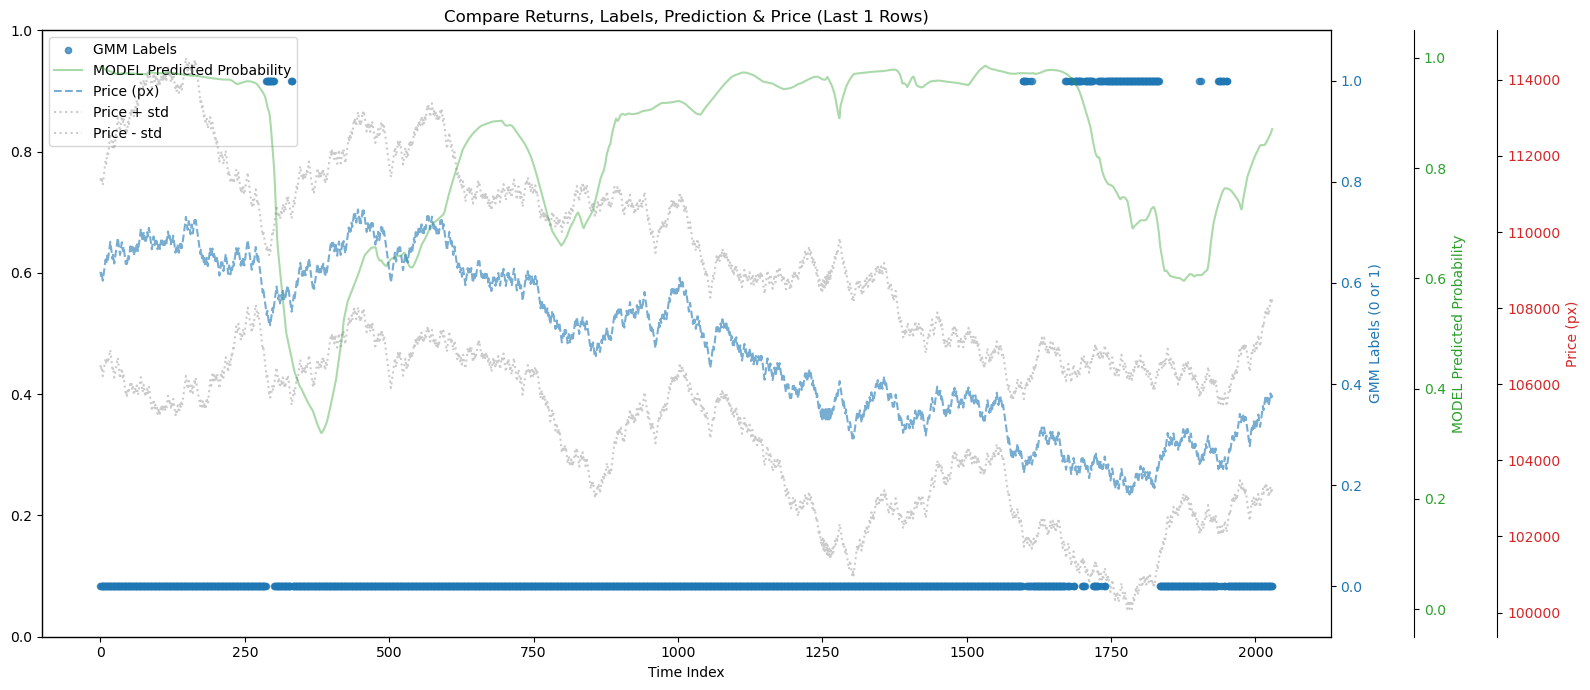

epoch 0  | loss: 0.38847 | val_0_accuracy: 0.56446 |  0:00:00s
epoch 5  | loss: 0.18637 | val_0_accuracy: 0.55525 |  0:00:01s
epoch 10 | loss: 0.16248 | val_0_accuracy: 0.54788 |  0:00:02s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_accuracy = 0.56446


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5645
✅ 自信预测准确率: 0.6239 (阈值 0.2-0.8)
📈 出手率: 70.35%

🧮 自信预测混淆矩阵:
[[   0  861]
 [   1 1430]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       861
           1       0.62      1.00      0.77      1431

    accuracy                           0.62      2292
   macro avg       0.31      0.50      0.38      2292
weighted avg       0.39      0.62      0.48      2292


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.2825
✅ 自信预测准确率: 0.1821 (阈值 0.2-0.8)
📈 出手率: 48.38%

🧮 自信预测混淆矩阵:
[[ 54 804]
 [  0 125]]

📝 分类报告:
              precision    recall  f1-score   support

           0       1.00      0.06      0.12       858
           1       0.13      1.00      0.24       125

    accuracy                           0.18       983
   macro avg       0.57      0.53      0.18       983
weighted avg       0.89      0.18      0.13       983



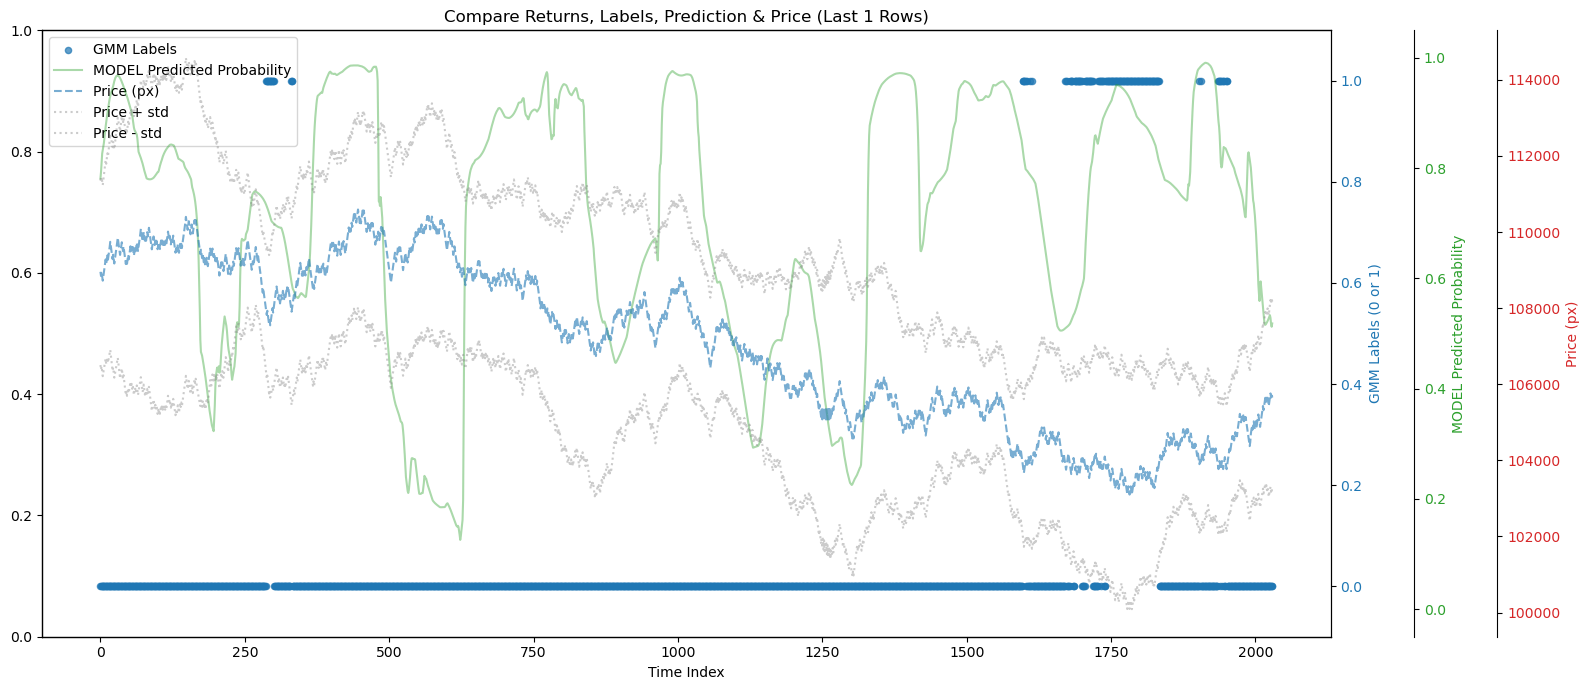

Test Week 6 Evaluation Completed
Fold 4: Train 4~6, Val 7, Test 8
Train: 2025-05-05 00:01:39.539000 to 2025-05-25 23:57:24.031000
Val: 2025-05-26 00:01:11.960000 to 2025-06-01 23:52:35.215000
Test: 2025-06-02 00:06:44.065000 to 2025-06-08 23:58:17.188000

=== lgb_model 评估结果 ===
📊 全样本准确率: 0.1240
✅ 自信预测准确率: 0.1146 (阈值 0.2-0.8)
📈 出手率: 95.77%

🧮 自信预测混淆矩阵:
[[  46 1723]
 [   0  177]]

📝 分类报告:
              precision    recall  f1-score   support

           0       1.00      0.03      0.05      1769
           1       0.09      1.00      0.17       177

    accuracy                           0.11      1946
   macro avg       0.55      0.51      0.11      1946
weighted avg       0.92      0.11      0.06      1946


=== lgb_model 评估结果 ===
📊 全样本准确率: 0.4702
✅ 自信预测准确率: 0.4494 (阈值 0.2-0.8)
📈 出手率: 88.59%

🧮 自信预测混淆矩阵:
[[  0 767]
 [ 11 635]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       767
           1       0.45      0.98      0.62

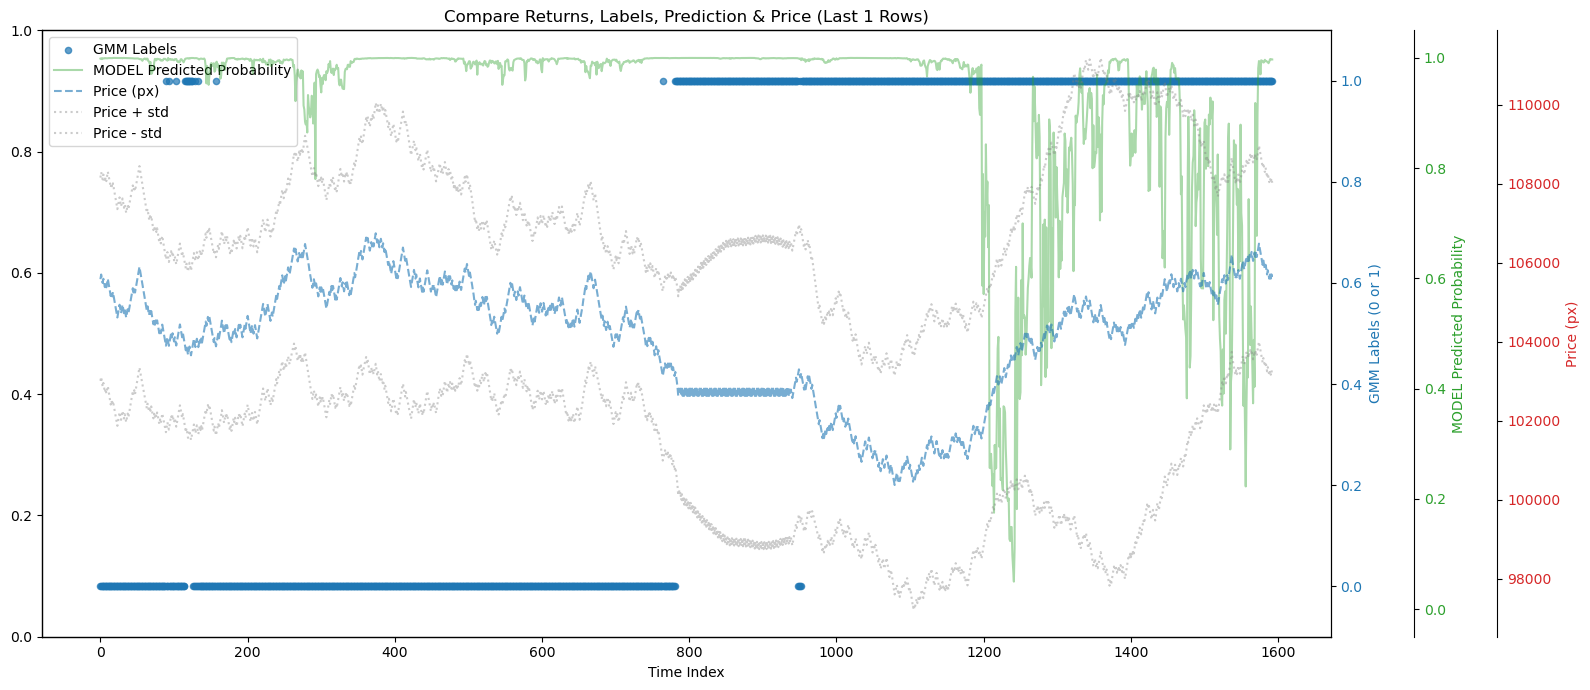

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79183 | val_0_accuracy: 0.08711 |  0:00:00s
epoch 5  | loss: 0.22048 | val_0_accuracy: 0.08711 |  0:00:01s
epoch 10 | loss: 0.17856 | val_0_accuracy: 0.08711 |  0:00:03s
epoch 15 | loss: 0.1399  | val_0_accuracy: 0.11319 |  0:00:04s
epoch 20 | loss: 0.14794 | val_0_accuracy: 0.08711 |  0:00:06s
epoch 25 | loss: 0.13801 | val_0_accuracy: 0.08268 |  0:00:08s
epoch 30 | loss: 0.12847 | val_0_accuracy: 0.12697 |  0:00:09s
epoch 35 | loss: 0.12348 | val_0_accuracy: 0.11417 |  0:00:11s
epoch 40 | loss: 0.12182 | val_0_accuracy: 0.13632 |  0:00:12s
epoch 45 | loss: 0.11678 | val_0_accuracy: 0.16289 |  0:00:14s
epoch 50 | loss: 0.1202  | val_0_accuracy: 0.13976 |  0:00:15s
epoch 55 | loss: 0.11722 | val_0_accuracy: 0.14911 |  0:00:17s
epoch 60 | loss: 0.11499 | val_0_accuracy: 0.13287 |  0:00:18s
epoch 65 | loss: 0.11567 | val_0_accuracy: 0.12008 |  0:00:20s

Early stopping occurred at epoch 66 with best_epoch = 46 and best_val_0_accuracy = 0.16486


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.1649
✅ 自信预测准确率: 0.1431 (阈值 0.2-0.8)
📈 出手率: 93.21%

🧮 自信预测混淆矩阵:
[[ 128 1609]
 [  14  143]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.90      0.07      0.14      1737
           1       0.08      0.91      0.15       157

    accuracy                           0.14      1894
   macro avg       0.49      0.49      0.14      1894
weighted avg       0.83      0.14      0.14      1894


=== tabnet 评估结果 ===
📊 全样本准确率: 0.6138
✅ 自信预测准确率: 0.6133 (阈值 0.2-0.8)
📈 出手率: 89.34%

🧮 自信预测混淆矩阵:
[[ 80 551]
 [  0 794]]

📝 分类报告:
              precision    recall  f1-score   support

           0       1.00      0.13      0.23       631
           1       0.59      1.00      0.74       794

    accuracy                           0.61      1425
   macro avg       0.80      0.56      0.48      1425
weighted avg       0.77      0.61      0.51      1425



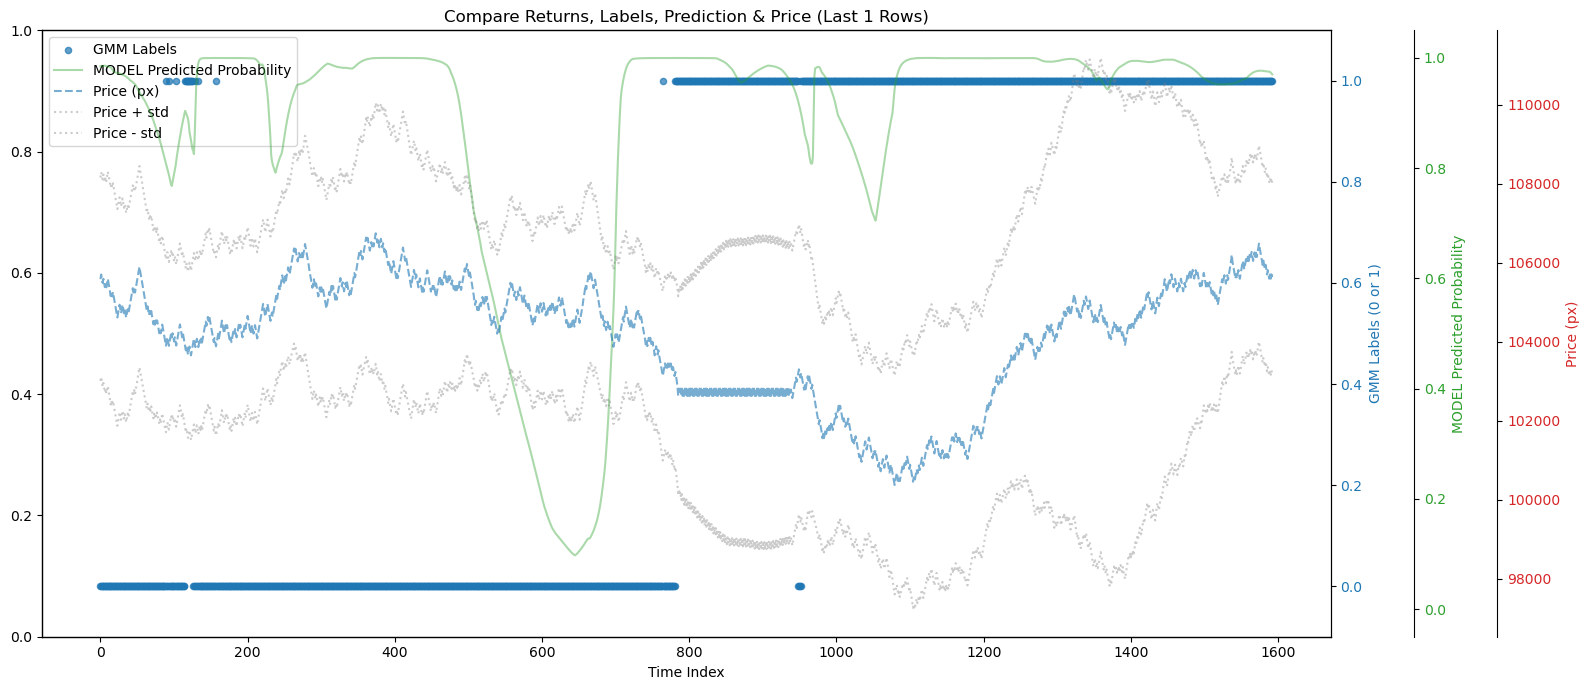

epoch 0  | loss: 0.45998 | val_0_accuracy: 0.2249  |  0:00:00s
epoch 5  | loss: 0.16184 | val_0_accuracy: 0.31644 |  0:00:01s
epoch 10 | loss: 0.13928 | val_0_accuracy: 0.37451 |  0:00:03s
epoch 15 | loss: 0.12442 | val_0_accuracy: 0.29281 |  0:00:04s
epoch 20 | loss: 0.12442 | val_0_accuracy: 0.36811 |  0:00:06s

Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_accuracy = 0.37451


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.3745
✅ 自信预测准确率: 0.2639 (阈值 0.2-0.8)
📈 出手率: 57.43%

🧮 自信预测混淆矩阵:
[[211 847]
 [ 12  97]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.95      0.20      0.33      1058
           1       0.10      0.89      0.18       109

    accuracy                           0.26      1167
   macro avg       0.52      0.54      0.26      1167
weighted avg       0.87      0.26      0.32      1167


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.4408
✅ 自信预测准确率: 0.4696 (阈值 0.2-0.8)
📈 出手率: 74.36%

🧮 自信预测混淆矩阵:
[[ 94 460]
 [169 463]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.36      0.17      0.23       554
           1       0.50      0.73      0.60       632

    accuracy                           0.47      1186
   macro avg       0.43      0.45      0.41      1186
weighted avg       0.43      0.47      0.42      1186



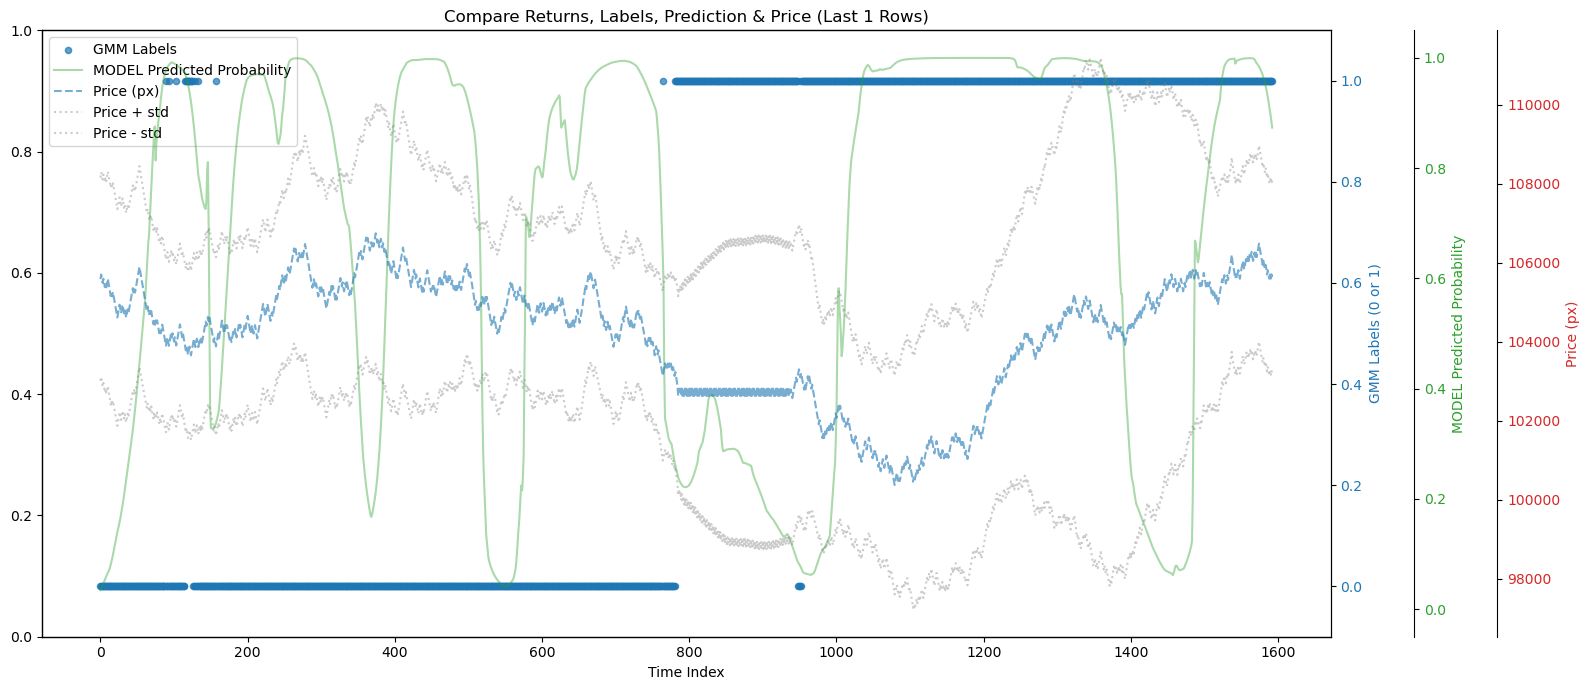

Test Week 7 Evaluation Completed
Fold 5: Train 5~7, Val 8, Test 9
Train: 2025-05-12 00:05:11.740000 to 2025-06-01 23:52:35.215000
Val: 2025-06-02 00:06:44.065000 to 2025-06-08 23:58:17.188000
Test: 2025-06-09 00:07:03.215000 to 2025-06-09 17:12:57.354000

=== lgb_model 评估结果 ===
📊 全样本准确率: 0.3944
✅ 自信预测准确率: 0.3961 (阈值 0.2-0.8)
📈 出手率: 74.23%

🧮 自信预测混淆矩阵:
[[ 78 492]
 [223 391]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.26      0.14      0.18       570
           1       0.44      0.64      0.52       614

    accuracy                           0.40      1184
   macro avg       0.35      0.39      0.35      1184
weighted avg       0.35      0.40      0.36      1184


=== lgb_model 评估结果 ===
📊 全样本准确率: 0.8784
✅ 自信预测准确率: 1.0000 (阈值 0.2-0.8)
📈 出手率: 60.81%

🧮 自信预测混淆矩阵:
[[90]]

📝 分类报告:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        90

    accuracy                           1.00        90
   macro

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


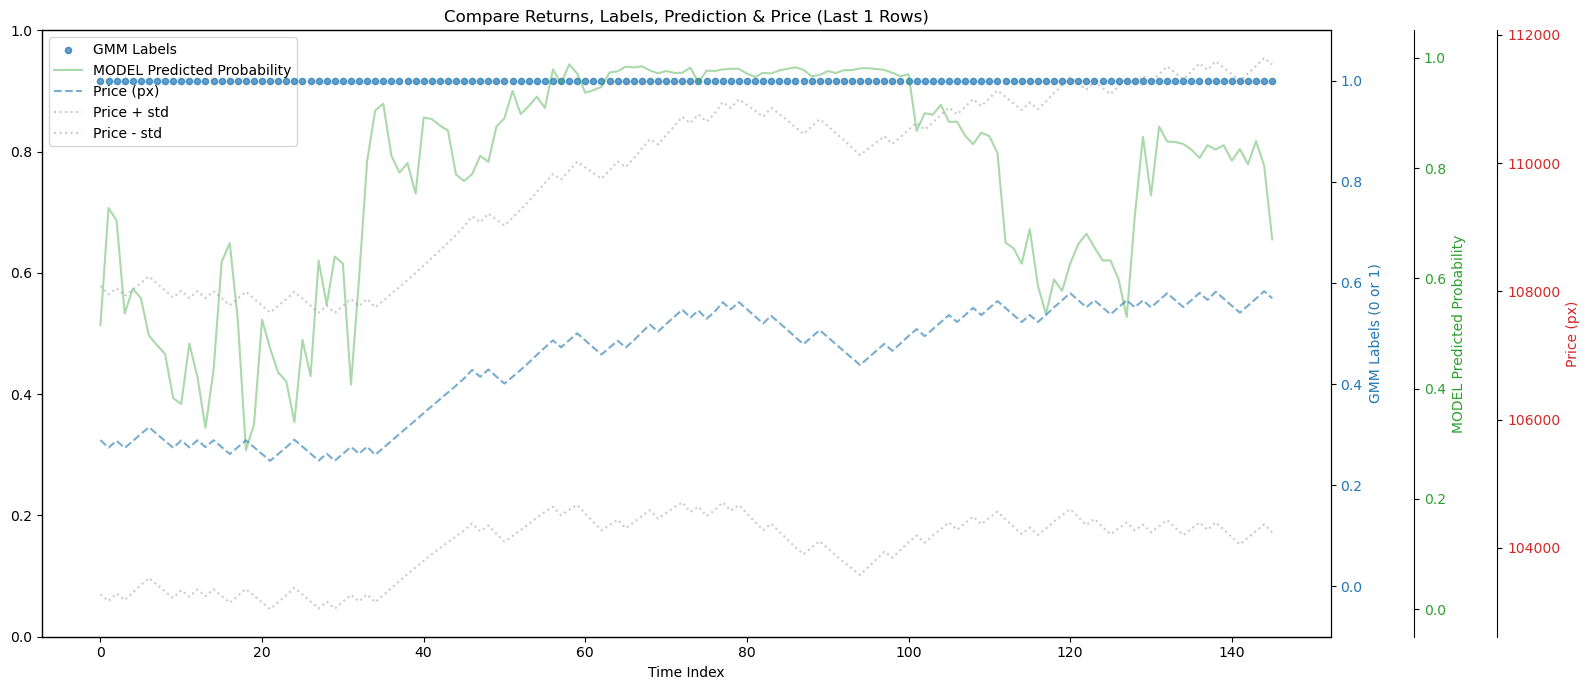

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.82926 | val_0_accuracy: 0.5185  |  0:00:00s
epoch 5  | loss: 0.21728 | val_0_accuracy: 0.54734 |  0:00:01s
epoch 10 | loss: 0.1365  | val_0_accuracy: 0.56803 |  0:00:03s
epoch 15 | loss: 0.12247 | val_0_accuracy: 0.55423 |  0:00:05s
epoch 20 | loss: 0.11115 | val_0_accuracy: 0.55611 |  0:00:06s
epoch 25 | loss: 0.11411 | val_0_accuracy: 0.54357 |  0:00:08s
epoch 30 | loss: 0.10903 | val_0_accuracy: 0.55799 |  0:00:09s

Early stopping occurred at epoch 31 with best_epoch = 11 and best_val_0_accuracy = 0.56991


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.5699
✅ 自信预测准确率: 0.5805 (阈值 0.2-0.8)
📈 出手率: 93.42%

🧮 自信预测混淆矩阵:
[[ 49 625]
 [  0 816]]

📝 分类报告:
              precision    recall  f1-score   support

           0       1.00      0.07      0.14       674
           1       0.57      1.00      0.72       816

    accuracy                           0.58      1490
   macro avg       0.78      0.54      0.43      1490
weighted avg       0.76      0.58      0.46      1490


=== tabnet 评估结果 ===
📊 全样本准确率: 1.0000
✅ 自信预测准确率: 1.0000 (阈值 0.2-0.8)
📈 出手率: 100.00%

🧮 自信预测混淆矩阵:
[[148]]

📝 分类报告:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       148

    accuracy                           1.00       148
   macro avg       1.00      1.00      1.00       148
weighted avg       1.00      1.00      1.00       148



C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


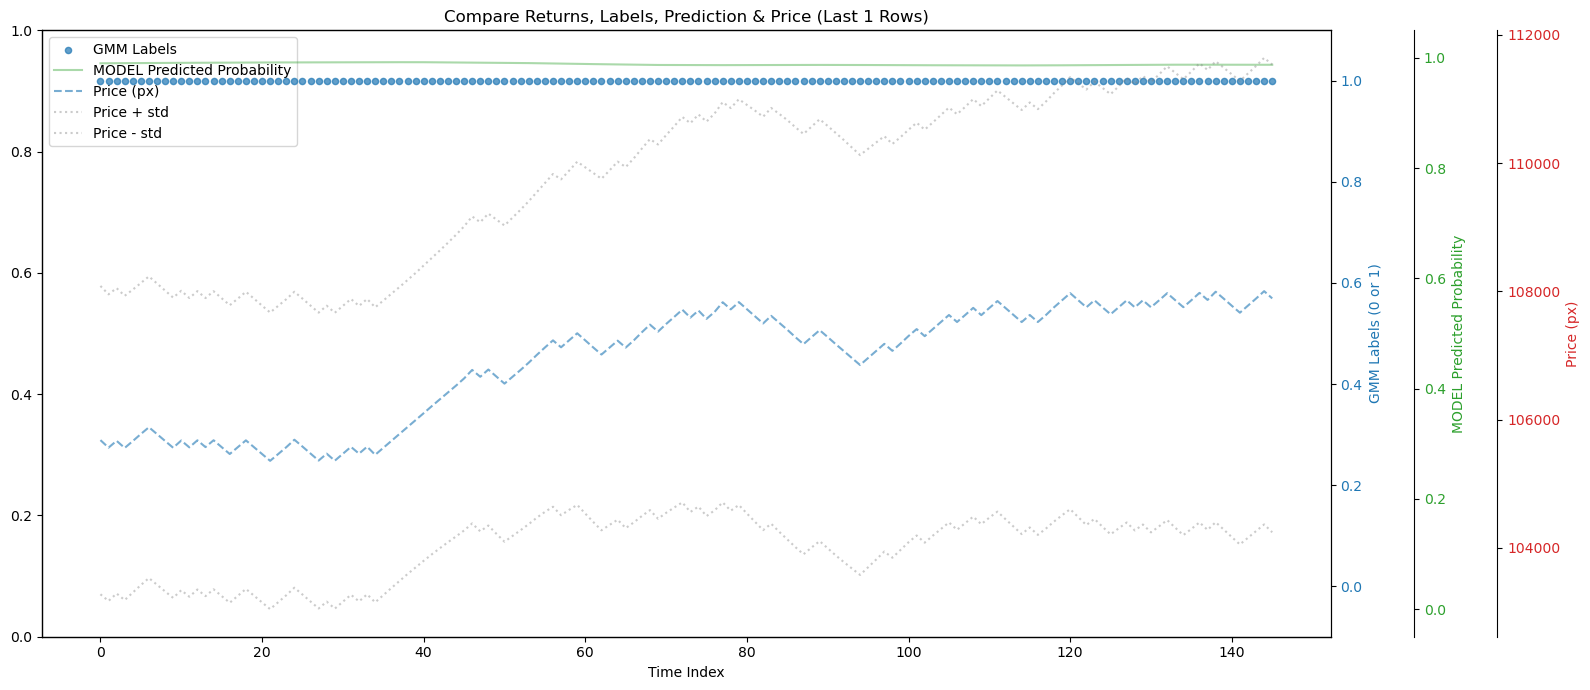

epoch 0  | loss: 0.43097 | val_0_accuracy: 0.51473 |  0:00:00s
epoch 5  | loss: 0.13659 | val_0_accuracy: 0.77555 |  0:00:01s
epoch 10 | loss: 0.12114 | val_0_accuracy: 0.71285 |  0:00:03s
epoch 15 | loss: 0.11794 | val_0_accuracy: 0.65768 |  0:00:05s

Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_accuracy = 0.77994


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.7799
✅ 自信预测准确率: 0.7700 (阈值 0.2-0.8)
📈 出手率: 64.33%

🧮 自信预测混淆矩阵:
[[453 138]
 [ 98 337]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.82      0.77      0.79       591
           1       0.71      0.77      0.74       435

    accuracy                           0.77      1026
   macro avg       0.77      0.77      0.77      1026
weighted avg       0.77      0.77      0.77      1026


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.3649
✅ 自信预测准确率: 0.3158 (阈值 0.2-0.8)
📈 出手率: 77.03%

🧮 自信预测混淆矩阵:
[[ 0  0]
 [78 36]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.32      0.48       114

    accuracy                           0.32       114
   macro avg       0.50      0.16      0.24       114
weighted avg       1.00      0.32      0.48       114



C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

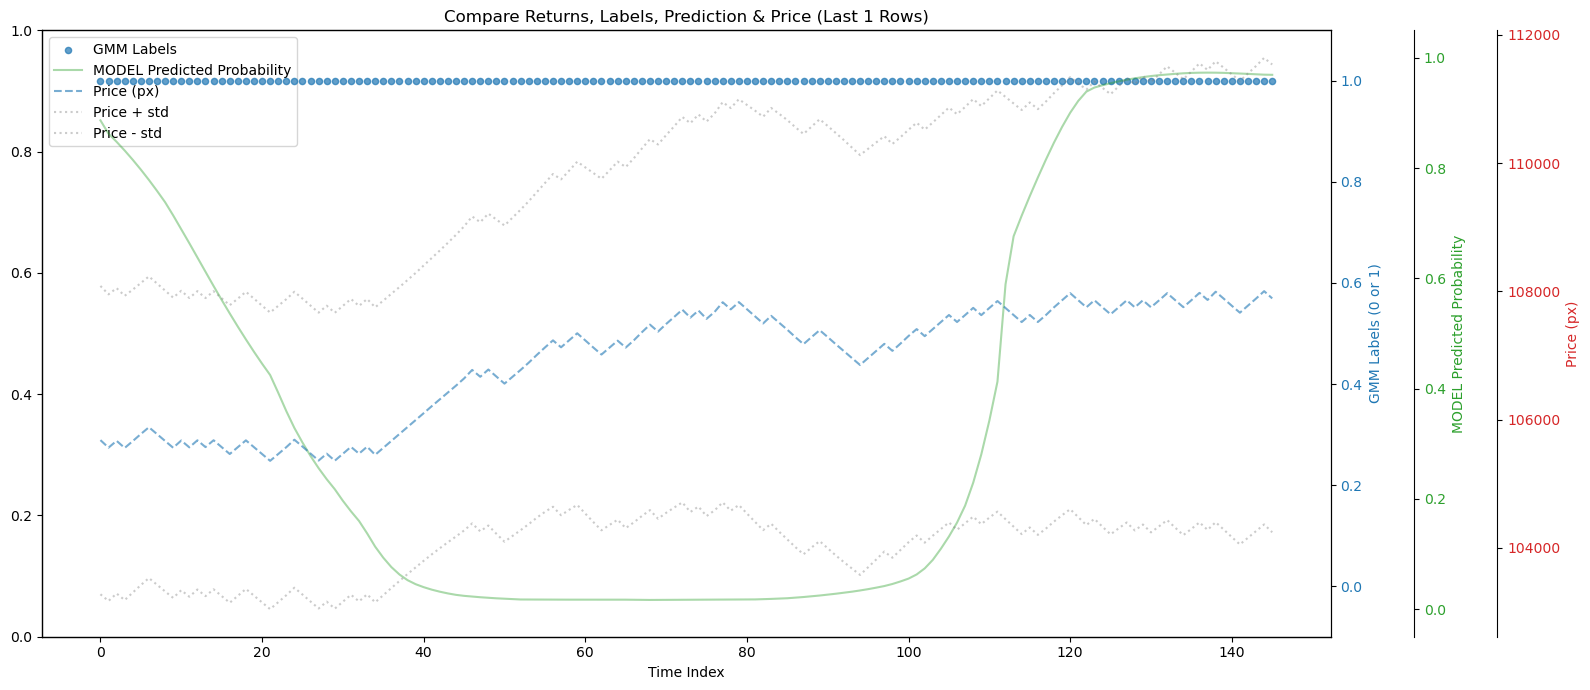

Test Week 8 Evaluation Completed

--- Final Predictions DataFrame for Backtesting ---
          timestamp   symbol  true_label  predicted_prob       px  rolling_std
0  1746403299539000  BTCUSDT           1        0.405440  94327.5   880.581846
1  1746403361421000  BTCUSDT           1        0.394003  94231.8   884.288109
2  1746403787531000  BTCUSDT           1        0.383570  94329.9   886.686524
3  1746403984261000  BTCUSDT           1        0.374139  94424.7   887.847991
4  1746404204389000  BTCUSDT           1        0.366310  94522.7   887.751235
Total rows collected: 11366


In [10]:
n_train_weeks = 3# 可配置
n_val_weeks = 1    # 一般 1 周验证
n_test_weeks = 1   # 后 1 周做 test

exclude_prefixes = ['px', 'timestamp', 'timestamp_dt', 'symbol']
target_col = "future_std_label"
feature_cols = [
    col for col in origin_df.columns
    if col.endswith("_scaled") 
        and (col.startswith("z_")) 
        and all(not col.startswith(prefix) for prefix in exclude_prefixes)
        and not col.startswith("future_return_")
        and col != "px"
]


# feature_cols = ["raw_factor_long_term_oi_trend"]
results = []
all_tab_inc_test_predictions = []
all_tabnet_test_predictions = []
all_lgb_test_predictions = []

lgb_model = None
tab_inc = None
tab_inc_flag = 0

for i in range(len(weekly_dataframes) - n_train_weeks - n_val_weeks - n_test_weeks + 1):
    train_dfs = weekly_dataframes[i : i + n_train_weeks]
    val_dfs = weekly_dataframes[i + n_train_weeks : i + n_train_weeks + n_val_weeks]
    test_dfs = weekly_dataframes[i + n_train_weeks + n_val_weeks : i + n_train_weeks + n_val_weeks + n_test_weeks]
    
    train_df = pl.concat(train_dfs)
    val_df = pl.concat(val_dfs)
    test_df = pl.concat(test_dfs)

    print("=" * 60)
    print(f"Fold {i}: Train {i}~{i+n_train_weeks-1}, Val {i+n_train_weeks}, Test {i+n_train_weeks+1}")
    print("Train:", train_df['timestamp_dt'][0], "to", train_df['timestamp_dt'][-1])
    print("Val:", val_df['timestamp_dt'][0], "to", val_df['timestamp_dt'][-1])
    print("Test:", test_df['timestamp_dt'][0], "to", test_df['timestamp_dt'][-1])
    
    # 处理 train
    train_df_processed = train_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_train = train_df_processed[feature_cols]
    y_train = train_df_processed[target_col]
    px_train = train_df_processed['px']
    std_train =train_df_processed['rolling_std']
    
    # 处理 val
    val_df_processed = val_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_val = val_df_processed[feature_cols]
    y_val = val_df_processed[target_col]
    px_val = val_df_processed['px']
    std_val =val_df_processed['rolling_std']
    timestamps_val = val_df_processed['timestamp'] # 收集时间戳

    # 处理 test
    test_df_processed = test_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_test = test_df_processed[feature_cols]
    y_test = test_df_processed[target_col]
    px_test = test_df_processed['px']
    std_test =test_df_processed['rolling_std']
    timestamps_test = test_df_processed['timestamp'] # 收集时间戳

    # modellllllll
    up_thresh = 0.2
    lower_thresh = 0.8
    
    # # #LGBM
    if lgb_model == None:
        lgb_model = lgb.LGBMClassifier(n_estimators=5000, learning_rate=0.005, max_depth=7, verbose=-1)
        early_stopping_callback = lgb.early_stopping(
            stopping_rounds=500,  # 耐心值：如果验证集性能在连续100轮内没有提升，就停止训练
            verbose=True,          # 打印早停信息，例如在第多少轮停止，最佳分数是多少
        )
        lgb_model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='acc',
            # callbacks=[early_stopping_callback], # 将早停回调传入 callbacks 参数
        )

    else:
        lgb_model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='acc',
            # callbacks=[early_stopping_callback], # 将早停回调传入 callbacks 参数
        )
    
    lgb_eval = evaluate_with_confidence(
        y_true=y_val,
        y_pred_proba=lgb_model.predict_proba(X_val)[:, 1],
        model_name="lgb_model",
        lower_thresh=up_thresh,
        upper_thresh=lower_thresh,
        print_report=True,
    )
    # plot_last_n_rows_with_px(y_val, y_val, lgb_model.predict_proba(X_val)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    
    lgb_eval = evaluate_with_confidence(
        y_true=y_test,
        y_pred_proba=lgb_model.predict_proba(X_test)[:, 1],
        model_name="lgb_model",
        lower_thresh=up_thresh,
        upper_thresh=lower_thresh,
        print_report=True,
    )
    plot_last_n_rows_with_px(lgb_model.predict_proba(X_test)[:, 1], y_test, lgb_model.predict_proba(X_test)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)
    lgb_test_pred_probs = lgb_model.predict_proba(X_test)[:, 1]

    current_window_results = pd.DataFrame({
        'timestamp': timestamps_test,
        'symbol': "BTCUSDT", # 如果有多个股票，收集 symbol 是必要的
        'true_label': y_test,
        'predicted_prob': lgb_test_pred_probs,
        'px': px_test, # 收集价格，回测时需要
        'rolling_std': std_test # 收集波动率，可能用于策略或分析
        # 添加任何你回测需要的其他数据
    })
    all_lgb_test_predictions.append(current_window_results)

    # # CAT
    # cat_model = CatBoostClassifier(iterations=2000, learning_rate=0.005, depth=9, verbose=0)
    # cat_model.fit(
    #     X_train, y_train_bin,
    # )

    # cat_eval = evaluate_with_confidence(
    #     y_true=y_val_bin,
    #     y_pred_proba=cat_model.predict_proba(X_val)[:, 1],
    #     model_name="cat_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_val, y_val_bin, cat_model.predict_proba(X_val)[:, 1], px_val, n=6199)
    
    # cat_eval = evaluate_with_confidence(
    #     y_true=y_test_bin,
    #     y_pred_proba=cat_model.predict_proba(X_test)[:, 1],
    #     model_name="cat_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_test, y_test_bin, cat_model.predict_proba(X_test)[:, 1], px_test, n=6199)

    # # XGB
    # xgb_model = xgb.XGBClassifier(n_estimators=2000, learning_rate=0.005, max_depth=9, verbosity=0, use_label_encoder=False)
    # xgb_model.fit(
    #     X_train, y_train,
    # )

    # xgb_eval = evaluate_with_confidence(
    #     y_true=y_val,
    #     y_pred_proba=xgb_model.predict_proba(X_val)[:, 1],
    #     model_name="xgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_val, y_val, xgb_model.predict_proba(X_val)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    

    # xgb_eval = evaluate_with_confidence(
    #     y_true=y_test,
    #     y_pred_proba=xgb_model.predict_proba(X_test)[:, 1],
    #     model_name="xgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_test, y_test, xgb_model.predict_proba(X_test)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)

    
    # Label Encode y（如果是0/1就不用）
    y_train_enc = y_train.astype(int)
    y_val_enc = y_val.astype(int)
    
    # TabNet 训练
    tabnet = TabNetClassifier(
        # n_d=32,
        # n_a=32,
        # n_steps=7,
        device_name='cuda' if torch.cuda.is_available() else 'cpu',
        verbose=5,
    )
    tabnet.fit(
        X_train=X_train.values, y_train=y_train_enc,
        eval_set=[(X_val.values, y_val_enc)],
        eval_metric=['accuracy'],
        max_epochs=200,
        patience=20,
        # batch_size=256,
        # virtual_batch_size=128,
    )

    tabnet_eval = evaluate_with_confidence(
        y_true=y_val,
        y_pred_proba=tabnet.predict_proba(X_val.values)[:, 1],
        model_name="tabnet",
        lower_thresh=up_thresh,
        upper_thresh=lower_thresh,
        print_report=True,
    )
    # plot_last_n_rows_with_px(y_val, y_val, tabnet.predict_proba(X_val.values)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)


    tabnet_eval = evaluate_with_confidence(
        y_true=y_test,
        y_pred_proba=tabnet.predict_proba(X_test.values)[:, 1],
        model_name="tabnet",
        lower_thresh=up_thresh,
        upper_thresh=lower_thresh,
        print_report=True,
    )
    plot_last_n_rows_with_px(tabnet.predict_proba(X_test.values)[:, 1], y_test, tabnet.predict_proba(X_test.values)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)

    tabnet_test_pred_probs = tabnet.predict_proba(X_test.values)[:, 1]

    current_window_results = pd.DataFrame({
        'timestamp': timestamps_test,
        'symbol': "BTCUSDT", # 如果有多个股票，收集 symbol 是必要的
        'true_label': y_test,
        'predicted_prob': tabnet_test_pred_probs,
        'px': px_test, # 收集价格，回测时需要
        'rolling_std': std_test # 收集波动率，可能用于策略或分析
        # 添加任何你回测需要的其他数据
    })
    all_tabnet_test_predictions.append(current_window_results)

    # TabNet_incremental 训练
    if tab_inc_flag == 0:
        tab_inc_flag = 1
        tab_inc = TabNetClassifier(
            # n_d=32,
            # n_a=32,
            # n_steps=7,
            device_name='cuda' if torch.cuda.is_available() else 'cpu',
            verbose=5,
        )
        tab_inc.fit(
            X_train=X_train.values, y_train=y_train_enc,
            eval_set=[(X_val.values, y_val_enc)],
            eval_metric=['accuracy'],
            max_epochs=200,
            patience=20,
            # batch_size=256,
            # virtual_batch_size=128,
        )
    
        tabnet_eval = evaluate_with_confidence(
            y_true=y_val,
            y_pred_proba=tab_inc.predict_proba(X_val.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        # plot_last_n_rows_with_px(y_val, y_val, tab_inc.predict_proba(X_val.values)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    
    
        tabnet_eval = evaluate_with_confidence(
            y_true=y_test,
            y_pred_proba=tab_inc.predict_proba(X_test.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        plot_last_n_rows_with_px(tab_inc.predict_proba(X_test.values)[:, 1], y_test, tab_inc.predict_proba(X_test.values)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)
        

    else:
        tab_inc.fit(
            X_train=X_train.values, y_train=y_train_enc,
            eval_set=[(X_val.values, y_val_enc)],
            eval_metric=['accuracy'],
            max_epochs=50,
            patience=10,
            # batch_size=256,
            # virtual_batch_size=128,
            warm_start=True,

        )
        
        tabnet_eval = evaluate_with_confidence(
            y_true=y_val,
            y_pred_proba=tab_inc.predict_proba(X_val.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        # plot_last_n_rows_with_px(y_val, y_val, tab_inc.predict_proba(X_val.values)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    
    
        tabnet_eval = evaluate_with_confidence(
            y_true=y_test,
            y_pred_proba=tab_inc.predict_proba(X_test.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        plot_last_n_rows_with_px(tab_inc.predict_proba(X_test.values)[:, 1], y_test, tab_inc.predict_proba(X_test.values)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)

    tab_inc_test_pred_probs = tab_inc.predict_proba(X_test.values)[:, 1]
    current_window_results = pd.DataFrame({
        'timestamp': timestamps_test,
        'symbol': "BTCUSDT", # 如果有多个股票，收集 symbol 是必要的
        'true_label': y_test,
        'predicted_prob': tab_inc_test_pred_probs,
        'px': px_test, # 收集价格，回测时需要
        'rolling_std': std_test # 收集波动率，可能用于策略或分析
        # 添加任何你回测需要的其他数据
    })
    all_tab_inc_test_predictions.append(current_window_results)

    week_results = {
        'train_period': f"{train_df['timestamp_dt'][0]} to {train_df['timestamp_dt'][-1]}",
        'test_period': f"{test_df['timestamp_dt'][0]} to {test_df['timestamp_dt'][-1]}",
        'LGBM': lgb_eval,
        # 'CatBoost': cat_model,
        # 'XGBoost': xgb_eval,
        'TabNet': tabnet_eval,
    }
    
    results.append(week_results)
    print(f"Test Week {i+n_train_weeks} Evaluation Completed")

final_predictions_df = pd.concat(all_tab_inc_test_predictions).sort_values('timestamp').reset_index(drop=True)

print("\n--- Final Predictions DataFrame for Backtesting ---")
print(final_predictions_df.head())
print(f"Total rows collected: {len(final_predictions_df)}") 


=== model 评估结果 ===
📊 全样本准确率: 0.5670
✅ 自信预测准确率: 0.5959 (阈值 0.2-0.8)
📈 出手率: 70.22%

🧮 自信预测混淆矩阵:
[[ 149 2906]
 [ 319 4607]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.32      0.05      0.08      3055
           1       0.61      0.94      0.74      4926

    accuracy                           0.60      7981
   macro avg       0.47      0.49      0.41      7981
weighted avg       0.50      0.60      0.49      7981



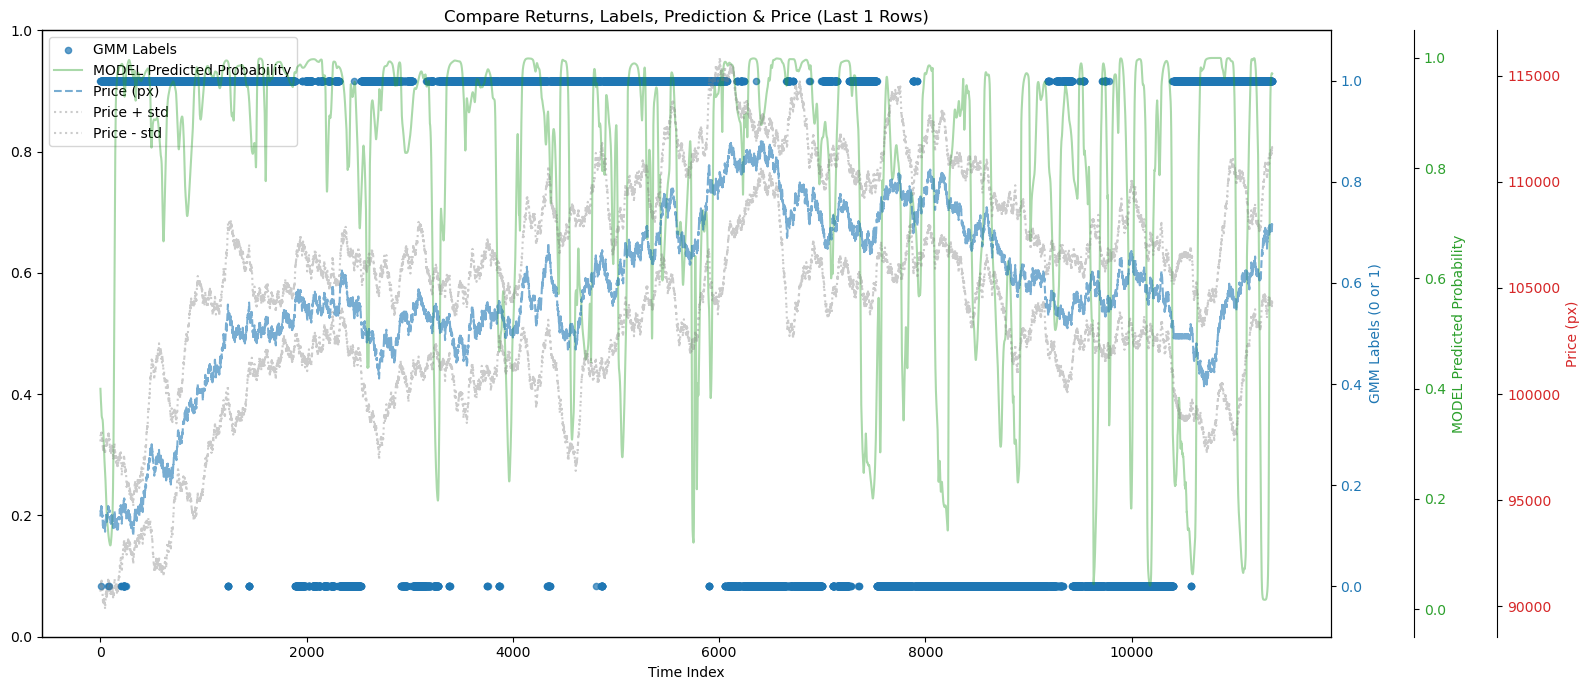

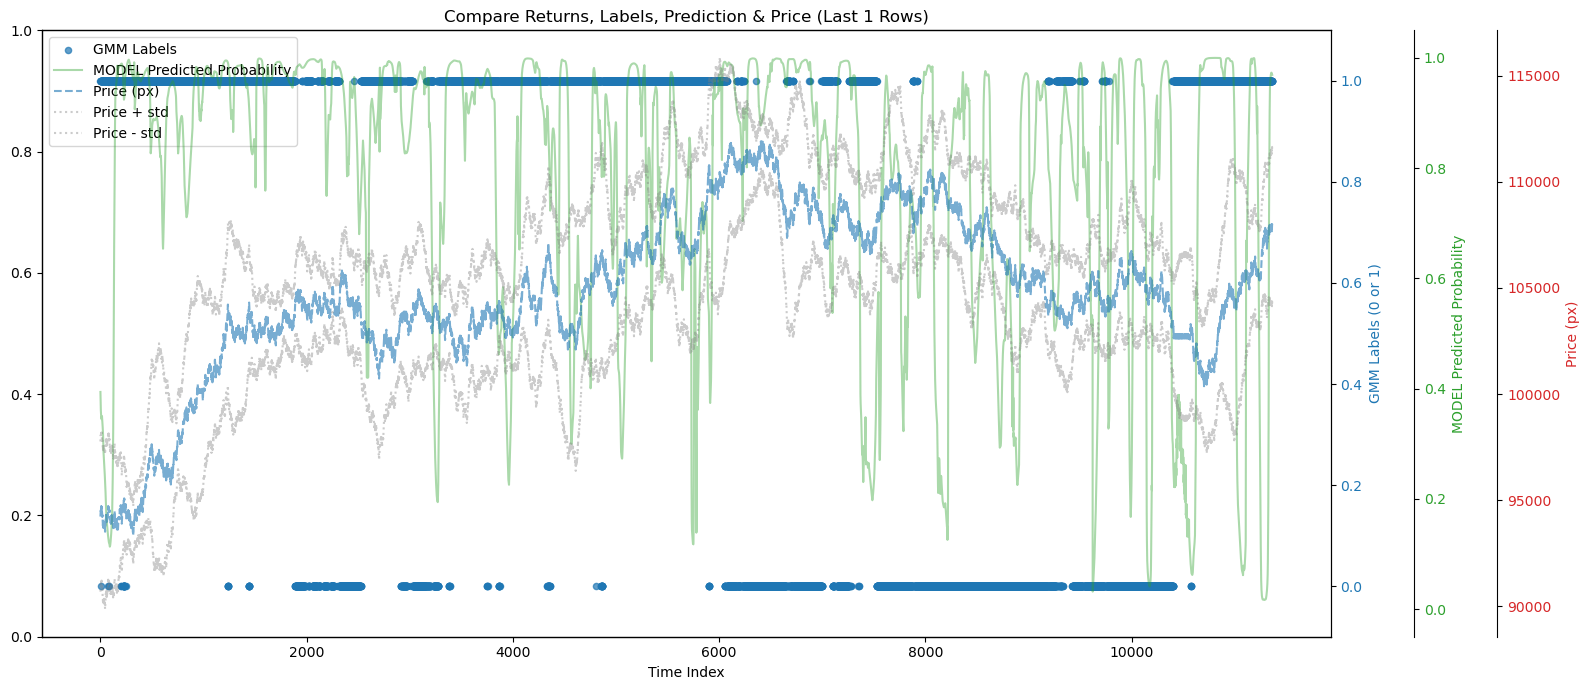

timestamp   symbol  true_label  predicted_prob        px  \
0      1746403299539000  BTCUSDT           1        0.405440   94327.5   
1      1746403361421000  BTCUSDT           1        0.394003   94231.8   
2      1746403787531000  BTCUSDT           1        0.383570   94329.9   
3      1746403984261000  BTCUSDT           1        0.374139   94424.7   
4      1746404204389000  BTCUSDT           1        0.366310   94522.7   
...                 ...      ...         ...             ...       ...   
11361  1749488607116000  BTCUSDT           1        0.971012  107777.0   
11362  1749488696174000  BTCUSDT           1        0.970241  107886.2   
11363  1749488832177000  BTCUSDT           1        0.969562  108001.6   
11364  1749489103490000  BTCUSDT           1        0.969305  107888.8   
11365  1749489177354000  BTCUSDT           1        0.968894  107999.1   

       rolling_std  predicted_prob_rolling_mean  
0       880.581846                     0.405440  
1       884.288109                     0.399722  
2       886.686524                     0.394338  
3       887.847991                     0.389288  
4       887.751235                     0.384692  
...            ...                          ...  
11361   905.008934                     0.972334  
11362   906.634776                     0.972251  
11363   909.376265                     0.972000  
11364   911.787690                     0.971655  
11365   915.199542                     0.971229  

[11366 rows x 7 columns]

In [11]:
rolling_window_size = 10

final_predictions_df = pd.concat(all_tab_inc_test_predictions).sort_values('timestamp').reset_index(drop=True)

final_predictions_df['predicted_prob_rolling_mean'] = final_predictions_df['predicted_prob'].rolling(window=rolling_window_size, min_periods=1).mean()

tabnet_eval = evaluate_with_confidence(
    y_true=final_predictions_df['true_label'],
    y_pred_proba=final_predictions_df['predicted_prob_rolling_mean'],
    model_name="model",
    lower_thresh=up_thresh,
    upper_thresh=lower_thresh,
    print_report=True,
)

plot_last_n_rows_with_px(
    final_predictions_df['predicted_prob_rolling_mean'], 
    final_predictions_df['true_label'],      
    final_predictions_df['predicted_prob_rolling_mean'], 
    final_predictions_df['px'],
    std_array=final_predictions_df['rolling_std'],
    n=1,
    m=-1,
    alpha=alpha,
)
plot_last_n_rows_with_px(
    final_predictions_df['predicted_prob'], 
    final_predictions_df['true_label'], 
    final_predictions_df['predicted_prob'], 
    final_predictions_df['px'], 
    std_array=final_predictions_df['rolling_std'], 
    n=1,
    m=-1, 
    alpha=alpha
)

final_predictions_df

In [12]:
# 计算未来 100 步收益

final_predictions_df['future_return_100'] = (
    final_predictions_df['px'].shift(-120) / final_predictions_df['px'] - 1
)


from scipy.stats import spearmanr

signal_col = 'predicted_prob_rolling_mean'
return_col = 'future_return_100'

ic_df = final_predictions_df[[signal_col, return_col]].dropna()
rank_ic, p_value = spearmanr(ic_df[signal_col], ic_df[return_col])

print(f"100步 Rank IC: {rank_ic:.4f}, p-value: {p_value:.4g}")


100步 Rank IC: 0.0522, p-value: 2.969e-08


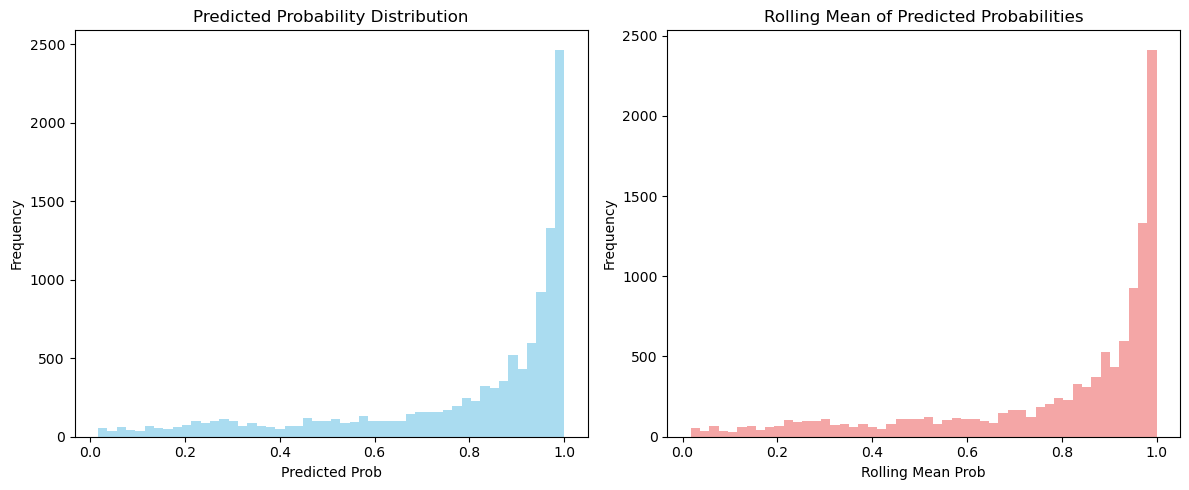

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 原始 predict_proba 分布
plt.subplot(1, 2, 1)
plt.hist(final_predictions_df['predicted_prob'], bins=50, alpha=0.7, color='skyblue')
plt.title('Predicted Probability Distribution')
plt.xlabel('Predicted Prob')
plt.ylabel('Frequency')

# 滚动均值分布
plt.subplot(1, 2, 2)
plt.hist(final_predictions_df['predicted_prob_rolling_mean'], bins=50, alpha=0.7, color='lightcoral')
plt.title('Rolling Mean of Predicted Probabilities')
plt.xlabel('Rolling Mean Prob')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



Backtesting Results Summary (Long-Short Strategy):
Initial Capital: 100000.00
Final Capital: 103085.35
Total Return: 3.09%
Total Realized PnL: 2974.55
年化收益 (近似): 36.42%
Maximum Drawdown: -11.03%
Sharpe Ratio (Risk-Free Rate = 0): 142.86
Number of Trades: 72
Win Rate: 55.56%


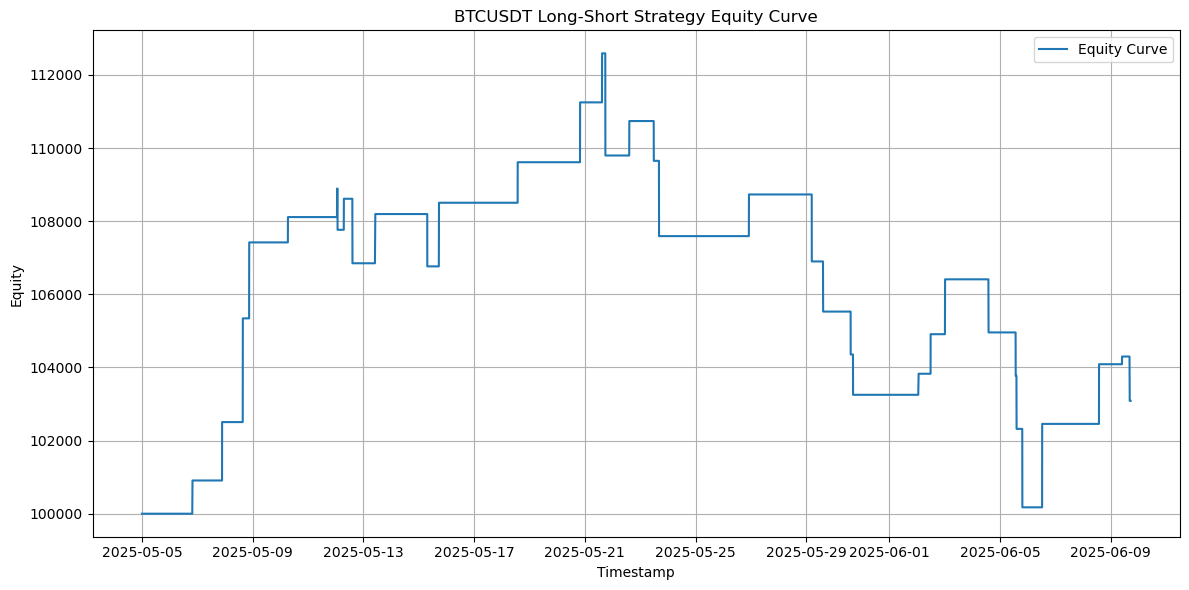

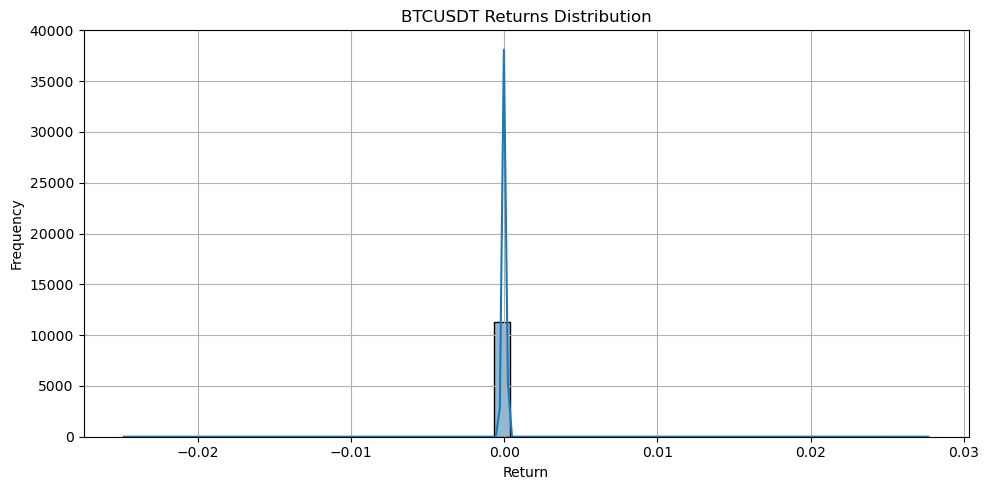

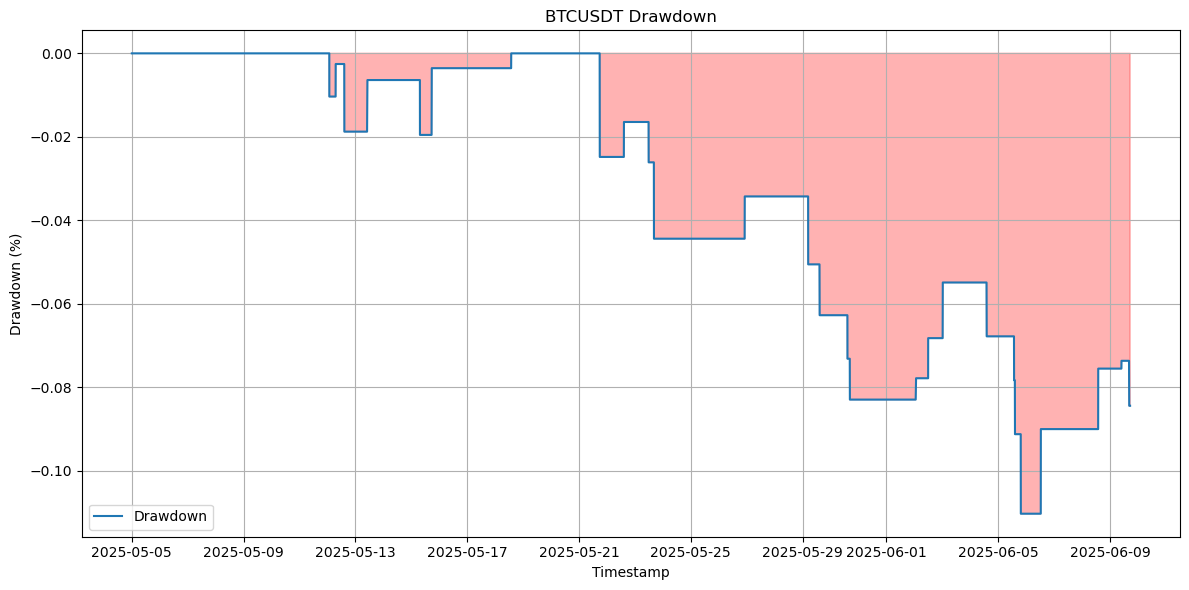

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

all_predictions_df = final_predictions_df
all_predictions_df['timestamp'] = pd.to_datetime(all_predictions_df['timestamp'], unit='us') # Assuming microseconds

symbol_to_backtest = all_predictions_df['symbol'].iloc[0] # Take the first symbol for now
df = all_predictions_df[all_predictions_df['symbol'] == symbol_to_backtest].copy()
df = df.sort_values('timestamp').reset_index(drop=True)

# ===============================================
# Backtesting Parameters (Ratios for costs)
# ===============================================
initial_capital = 100000  # Initial capital
commission_ratio = 0.0005 # Commission ratio (e.0.05%)
slippage_ratio = 0.001   # Slippage ratio (e.g., 0.02%)

trade_size_ratio = 0.9    # Percentage of current equity to allocate per trade

# Strategy Thresholds (needs optimization)
long_threshold = 0.95# Predicted probability above this to go long (buy)
short_threshold = 0.05

beta = 3
# Dynamic Take Profit / Stop Loss (in multiples of rolling_std/px)
long_stop_loss_multiplier = beta
long_take_profit_multiplier = beta
short_stop_loss_multiplier = beta
short_take_profit_multiplier = beta

# ===============================================
# Backtesting Main Logic (No change here from previous version)
# ===============================================

# Initialize account state
capital = initial_capital
position = 0          # Position size (positive for long, negative for short, 0 for flat)
entry_price = 0       # Entry price for current position
realized_pnl = 0      # Realized PnL from closed trades
equity_curve = [initial_capital] # Equity curve

# Record trades
trades = []

for i in range(len(df)):
    current_time = df['timestamp'].iloc[i]
    current_px = df['px'].iloc[i]
    predicted_prob = df['predicted_prob_rolling_mean'].iloc[i]
    current_rolling_std = df['rolling_std'].iloc[i]

    # Calculate current total equity (capital + market value of position)
    if position > 0: # Long position
        unrealized_pnl = (current_px - entry_price) * position
    elif position < 0: # Short position
        unrealized_pnl = (entry_price - current_px) * abs(position) # Profit when price falls
    else: # Flat
        unrealized_pnl = 0

    current_equity = capital
    equity_curve.append(current_equity)

    # -----------------------------------------------
    # Strategy Execution - Long-Short
    # -----------------------------------------------

    # Scenario 1: Currently FLAT (position == 0)
    if position == 0:
        if predicted_prob >= long_threshold: # Go Long Signal
            trade_type = 'BUY_OPEN'
            trade_price = current_px * (1 + slippage_ratio)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = num_shares
                entry_price = trade_price
                # capital -= (position * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

        elif predicted_prob <= short_threshold: # Go Short Signal
            trade_type = 'SELL_SHORT_OPEN'
            trade_price = current_px * (1 - slippage_ratio) # Price for short is lower (sell at market)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = -num_shares # Negative for short position
                entry_price = trade_price
                # capital -= (abs(position) * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

    # Scenario 2: Currently LONG (position > 0)
    elif position > 0:
        sl_price = entry_price - long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price + long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob < short_threshold: # Changed from sell_threshold to short_threshold for consistent logic
            should_close = True
            reason = "Prediction below short threshold (close long)"
        if current_px <= sl_price:
            should_close = True
            reason = "Long Stop Loss Hit"
        elif current_px >= tp_price:
            should_close = True
            reason = "Long Take Profit Hit"

        if should_close:
            trade_type = 'SELL_CLOSE_LONG'
            close_price = current_px * (1 - slippage_ratio)
            gross_pnl_on_trade = (close_price - entry_price) * position
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * position * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {position:.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0


    # Scenario 3: Currently SHORT (position < 0)
    elif position < 0:
        sl_price = entry_price + long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price - long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob >= long_threshold: # Changed from buy_threshold to long_threshold
            should_close = True
            reason = "Prediction above long threshold (close short)"
        if current_px >= sl_price:
            should_close = True
            reason = "Short Stop Loss Hit"
        elif current_px <= tp_price:
            should_close = True
            reason = "Short Take Profit Hit"

        if should_close:
            trade_type = 'BUY_TO_COVER_SHORT'
            close_price = current_px * (1 + slippage_ratio)
            gross_pnl_on_trade = (entry_price - close_price) * abs(position)
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * abs(position) * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade
 
            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {abs(position):.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0

# Final close-out at the end of backtest if any position is open
final_equity_append_time = df['timestamp'].iloc[-1] + pd.Timedelta(seconds=1)
if position != 0:
    last_px = df['px'].iloc[-1]
    if position > 0: # Close long
        final_close_price = last_px * (1 - slippage_ratio)
        gross_pnl_on_trade = (final_close_price - entry_price) * position
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * position * commission_ratio)
        # capital += (position * final_close_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'SELL_FINAL_LONG', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: SELL_FINAL_LONG {position:.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    else: # Close short
        final_close_price = last_px * (1 + slippage_ratio)
        gross_pnl_on_trade = (entry_price - final_close_price) * abs(position)
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * abs(position) * commission_ratio)
        # capital += (abs(position) * entry_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'BUY_FINAL_SHORT', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: BUY_FINAL_SHORT {abs(position):.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    realized_pnl += net_pnl_on_trade
    position = 0

# Final equity curve update
equity_curve[-1] = capital

# ===============================================
# Performance Metrics Calculation (KEY CHANGES HERE)
# ===============================================
equity_series = pd.Series(equity_curve, index=df['timestamp'].tolist() + [final_equity_append_time])
returns = equity_series.pct_change().dropna()

# Total Return
total_return = (capital - initial_capital) / initial_capital

# Annualized Return - Based on Total Duration
annualized_return = total_return # Default value if not enough data

if len(df) > 1:
    # Get the total duration of the backtest data
    total_duration = df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]
    total_duration_seconds = total_duration.total_seconds()

    if total_duration_seconds > 0:
        # Number of seconds in a year
        seconds_in_year = 365 * 24 * 60 * 60

        # Annualization factor: (seconds in a year) / (total seconds in backtest)
        annualization_factor = seconds_in_year / total_duration_seconds

        # Apply annualization
        annualized_return = (1 + total_return)**annualization_factor - 1
    else:
        print("Warning: Total backtest duration is zero or invalid, cannot annualize return.")
else:
    print("Warning: Not enough data points to calculate total duration for annualization.")


# Max Drawdown
peak = equity_series.expanding(min_periods=1).max()
drawdown = (equity_series - peak) / peak
max_drawdown = drawdown.min()

# Sharpe Ratio (assuming risk-free rate is 0)
# For volatility, we use returns.std() and annualize it with the same factor
annualized_volatility = returns.std() * np.sqrt(annualization_factor) if 'annualization_factor' in locals() and annualization_factor > 0 else returns.std()
sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

# Win Rate for closed trades
if len(trades) > 0:
    winning_trades = sum(1 for t in trades if 'pnl' in t and t['pnl'] > 0)
    total_closed_trades = sum(1 for t in trades if 'pnl' in t)
    win_rate = winning_trades / total_closed_trades if total_closed_trades > 0 else 0
else:
    win_rate = 0


print("\n" + "="*60)
print("Backtesting Results Summary (Long-Short Strategy):")
print(f"Initial Capital: {initial_capital:.2f}")
print(f"Final Capital: {capital:.2f}")
print(f"Total Return: {total_return:.2%}")
print(f"Total Realized PnL: {realized_pnl:.2f}")
print(f"年化收益 (近似): {annualized_return:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio (Risk-Free Rate = 0): {sharpe_ratio:.2f}")
print(f"Number of Trades: {len(trades)}")
print(f"Win Rate: {win_rate:.2%}")
print("="*60)

# ===============================================
# Plotting
# ===============================================

# Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(equity_series.index, equity_series, label='Equity Curve')
plt.title(f'{symbol_to_backtest} Long-Short Strategy Equity Curve')
plt.xlabel('Timestamp')
plt.ylabel('Equity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Returns Distribution
if not returns.empty:
    plt.figure(figsize=(10, 5))
    sns.histplot(returns, kde=True, bins=50)
    plt.title(f'{symbol_to_backtest} Returns Distribution')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Drawdown Plot
if not drawdown.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(drawdown.index, drawdown, label='Drawdown')
    plt.fill_between(drawdown.index, drawdown, 0, where=(drawdown < 0), color='red', alpha=0.3)
    plt.title(f'{symbol_to_backtest} Drawdown')
    plt.xlabel('Timestamp')
    plt.ylabel('Drawdown (%)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Backtesting Results Summary (Long-Short Strategy):
Initial Capital: 100000.00
Final Capital: 99225.58
Total Return: -0.77%
Total Realized PnL: -881.07
年化收益 (近似): -7.64%
Maximum Drawdown: -13.78%
Sharpe Ratio (Risk-Free Rate = 0): -27.68
Number of Trades: 72
Win Rate: 47.22%


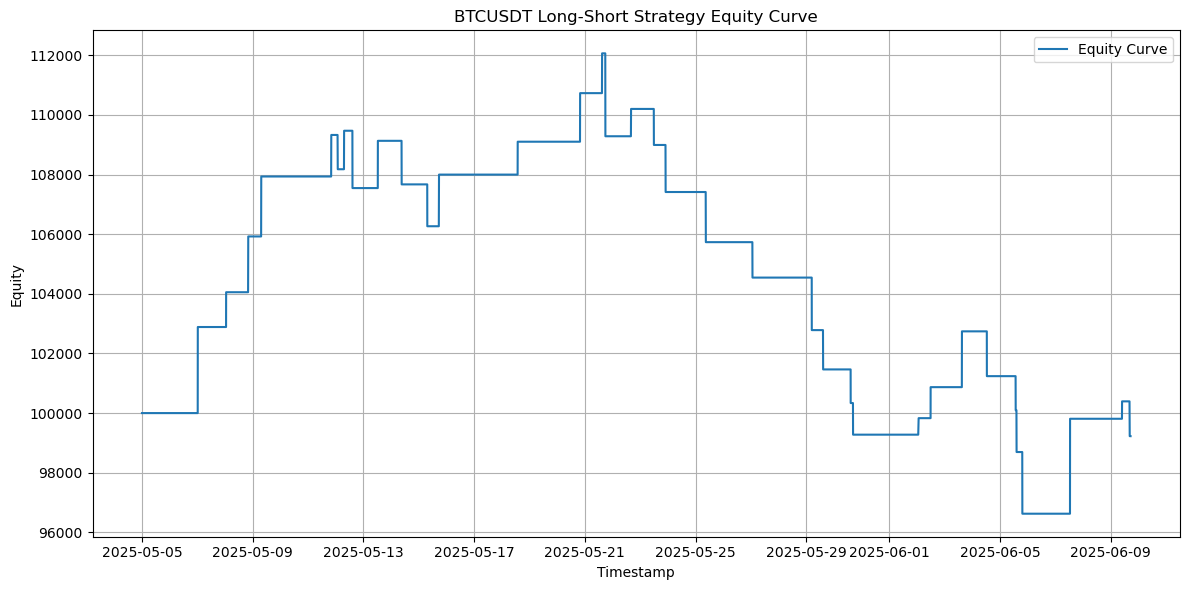

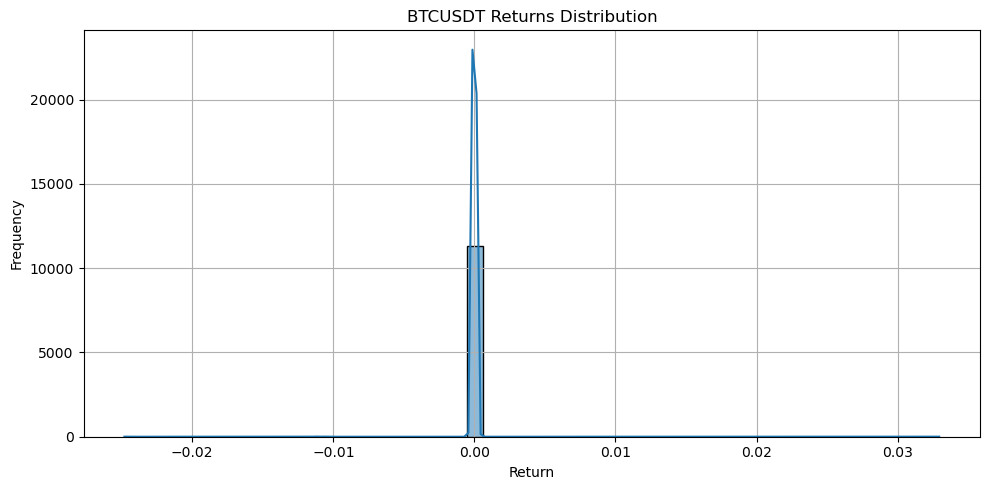

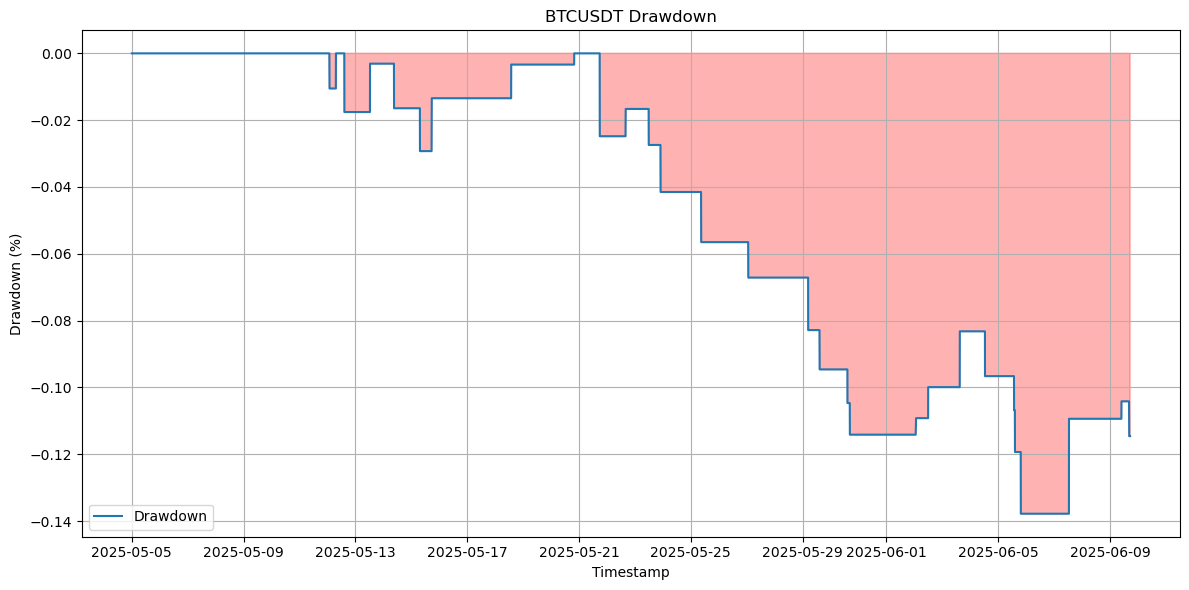

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

all_predictions_df = final_predictions_df
all_predictions_df['timestamp'] = pd.to_datetime(all_predictions_df['timestamp'], unit='us') # Assuming microseconds

symbol_to_backtest = all_predictions_df['symbol'].iloc[0] # Take the first symbol for now
df = all_predictions_df[all_predictions_df['symbol'] == symbol_to_backtest].copy()
df = df.sort_values('timestamp').reset_index(drop=True)

# ===============================================
# Backtesting Parameters (Ratios for costs)
# ===============================================
initial_capital = 100000  # Initial capital
commission_ratio = 0.0005 # Commission ratio (e.0.05%)
slippage_ratio = 0.001   # Slippage ratio (e.g., 0.02%)

trade_size_ratio = 0.9    # Percentage of current equity to allocate per trade

# Strategy Thresholds (needs optimization)
long_threshold = 0.95 # Predicted probability above this to go long (buy)
short_threshold = 0.05 # Predicted probability below this to go short (sell)

beta = 3
# Dynamic Take Profit / Stop Loss (in multiples of rolling_std/px)
long_stop_loss_multiplier = beta
long_take_profit_multiplier = beta
short_stop_loss_multiplier = beta
short_take_profit_multiplier = beta

# ===============================================
# Backtesting Main Logic (No change here from previous version)
# ===============================================

# Initialize account state
capital = initial_capital
position = 0          # Position size (positive for long, negative for short, 0 for flat)
entry_price = 0       # Entry price for current position
realized_pnl = 0      # Realized PnL from closed trades
equity_curve = [initial_capital] # Equity curve

# Record trades
trades = []

for i in range(len(df)):
    current_time = df['timestamp'].iloc[i]
    current_px = df['px'].iloc[i]
    predicted_prob = df['predicted_prob_rolling_mean'].iloc[i]
    current_rolling_std = df['rolling_std'].iloc[i]

    # Calculate current total equity (capital + market value of position)
    if position > 0: # Long position
        unrealized_pnl = (current_px - entry_price) * position
    elif position < 0: # Short position
        unrealized_pnl = (entry_price - current_px) * abs(position) # Profit when price falls
    else: # Flat
        unrealized_pnl = 0

    current_equity = capital
    equity_curve.append(current_equity)

    # -----------------------------------------------
    # Strategy Execution - Long-Short
    # -----------------------------------------------

    # Scenario 1: Currently FLAT (position == 0)
    if position == 0:
        if predicted_prob >= long_threshold: # Go Long Signal
            trade_type = 'BUY_OPEN'
            trade_price = current_px * (1 + slippage_ratio)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = num_shares
                entry_price = trade_price
                # capital -= (position * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

        elif predicted_prob <= short_threshold: # Go Short Signal
            trade_type = 'SELL_SHORT_OPEN'
            trade_price = current_px * (1 - slippage_ratio) # Price for short is lower (sell at market)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = -num_shares # Negative for short position
                entry_price = trade_price
                # capital -= (abs(position) * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

    # Scenario 2: Currently LONG (position > 0)
    elif position > 0:
        sl_price = entry_price - long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price + long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob < short_threshold: # Changed from sell_threshold to short_threshold for consistent logic
            should_close = True
            reason = "Prediction below short threshold (close long)"
        if current_px <= sl_price:
            should_close = True
            reason = "Long Stop Loss Hit"
        elif current_px >= tp_price and predicted_prob < long_threshold:
            should_close = True
            reason = "Long Take Profit Hit"

        if should_close:
            trade_type = 'SELL_CLOSE_LONG'
            close_price = current_px * (1 - slippage_ratio)
            gross_pnl_on_trade = (close_price - entry_price) * position
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * position * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {position:.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0


    # Scenario 3: Currently SHORT (position < 0)
    elif position < 0:
        sl_price = entry_price + long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price - long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob >= long_threshold: # Changed from buy_threshold to long_threshold
            should_close = True
            reason = "Prediction above long threshold (close short)"
        if current_px >= sl_price:
            should_close = True
            reason = "Short Stop Loss Hit"
        elif current_px <= tp_price and predicted_prob > short_threshold:
            should_close = True
            reason = "Short Take Profit Hit"

        if should_close:
            trade_type = 'BUY_TO_COVER_SHORT'
            close_price = current_px * (1 + slippage_ratio)
            gross_pnl_on_trade = (entry_price - close_price) * abs(position)
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * abs(position) * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {abs(position):.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0

# Final close-out at the end of backtest if any position is open
final_equity_append_time = df['timestamp'].iloc[-1] + pd.Timedelta(seconds=1)
if position != 0:
    last_px = df['px'].iloc[-1]
    if position > 0: # Close long
        final_close_price = last_px * (1 - slippage_ratio)
        gross_pnl_on_trade = (final_close_price - entry_price) * position
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * position * commission_ratio)
        # capital += (position * final_close_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'SELL_FINAL_LONG', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: SELL_FINAL_LONG {position:.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    else: # Close short
        final_close_price = last_px * (1 + slippage_ratio)
        gross_pnl_on_trade = (entry_price - final_close_price) * abs(position)
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * abs(position) * commission_ratio)
        # capital += (abs(position) * entry_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'BUY_FINAL_SHORT', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: BUY_FINAL_SHORT {abs(position):.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    realized_pnl += net_pnl_on_trade
    position = 0

# Final equity curve update
equity_curve[-1] = capital

# ===============================================
# Performance Metrics Calculation (KEY CHANGES HERE)
# ===============================================
equity_series = pd.Series(equity_curve, index=df['timestamp'].tolist() + [final_equity_append_time])
returns = equity_series.pct_change().dropna()

# Total Return
total_return = (capital - initial_capital) / initial_capital

# Annualized Return - Based on Total Duration
annualized_return = total_return # Default value if not enough data

if len(df) > 1:
    # Get the total duration of the backtest data
    total_duration = df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]
    total_duration_seconds = total_duration.total_seconds()

    if total_duration_seconds > 0:
        # Number of seconds in a year
        seconds_in_year = 365 * 24 * 60 * 60

        # Annualization factor: (seconds in a year) / (total seconds in backtest)
        annualization_factor = seconds_in_year / total_duration_seconds

        # Apply annualization
        annualized_return = (1 + total_return)**annualization_factor - 1
    else:
        print("Warning: Total backtest duration is zero or invalid, cannot annualize return.")
else:
    print("Warning: Not enough data points to calculate total duration for annualization.")


# Max Drawdown
peak = equity_series.expanding(min_periods=1).max()
drawdown = (equity_series - peak) / peak
max_drawdown = drawdown.min()

# Sharpe Ratio (assuming risk-free rate is 0)
# For volatility, we use returns.std() and annualize it with the same factor
annualized_volatility = returns.std() * np.sqrt(annualization_factor) if 'annualization_factor' in locals() and annualization_factor > 0 else returns.std()
sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

# Win Rate for closed trades
if len(trades) > 0:
    winning_trades = sum(1 for t in trades if 'pnl' in t and t['pnl'] > 0)
    total_closed_trades = sum(1 for t in trades if 'pnl' in t)
    win_rate = winning_trades / total_closed_trades if total_closed_trades > 0 else 0
else:
    win_rate = 0


print("\n" + "="*60)
print("Backtesting Results Summary (Long-Short Strategy):")
print(f"Initial Capital: {initial_capital:.2f}")
print(f"Final Capital: {capital:.2f}")
print(f"Total Return: {total_return:.2%}")
print(f"Total Realized PnL: {realized_pnl:.2f}")
print(f"年化收益 (近似): {annualized_return:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio (Risk-Free Rate = 0): {sharpe_ratio:.2f}")
print(f"Number of Trades: {len(trades)}")
print(f"Win Rate: {win_rate:.2%}")
print("="*60)

# ===============================================
# Plotting
# ===============================================

# Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(equity_series.index, equity_series, label='Equity Curve')
plt.title(f'{symbol_to_backtest} Long-Short Strategy Equity Curve')
plt.xlabel('Timestamp')
plt.ylabel('Equity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Returns Distribution
if not returns.empty:
    plt.figure(figsize=(10, 5))
    sns.histplot(returns, kde=True, bins=50)
    plt.title(f'{symbol_to_backtest} Returns Distribution')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Drawdown Plot
if not drawdown.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(drawdown.index, drawdown, label='Drawdown')
    plt.fill_between(drawdown.index, drawdown, 0, where=(drawdown < 0), color='red', alpha=0.3)
    plt.title(f'{symbol_to_backtest} Drawdown')
    plt.xlabel('Timestamp')
    plt.ylabel('Drawdown (%)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()